# Project Code: Simulation & Analysis

Instructions on how to run the code: 
1. Click 'Restart & Run All' under 'Kernel' in the top bar. 
2. All results including population estimtes and analysis will print. Each section is labeled with a header. 

In [1]:
import pandas as pd
import numpy as np
import random
from scipy.stats import poisson
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.stats import norm

In [2]:
#current policy parameters
c_funding = 225 * (10 ** 6) #annual funding for rescuing; $225M
c_rescue = 75 #cost per rescue
us_cat_to_human_prop = 0.33
curr_r0 = 0.13
curr_r_i = 0.03 #rate of immigration into feral (accts for deaths due to environmental/lifestyle changes)
curr_pop_cap = 150 * (10 ** 6) #200M
pop_2021 = 70 * (10 ** 6)
curr_death_prop = 0.25

p_d = 0.25 #prob of death averaged over all ages 
#y_s = 225 * (10 ** 6)  #funding for shelter TNR ops; or can make cost of TNR free for shelter
                        # since it was covered in the adoptions fee
curr_y_f = 0 * (10 ** 6)  #funding for TNR facility, changes based on economy
r_tnr_s = 46 * 12 #per shelter annually
r_tnr_f_avg = 360 * 12 #per TNR facility annually
r_tnr_f_std = 0.1 * r_tnr_f_avg
n_s = 3500 #fixed, don't change
s = 0.5
curr_p_tnr_s = 0.568
curr_c_tnr = 75 #trap, neuter, and release
c_space_per_cat = 150 #cost of space to house 1 cat in facility 
c_d = 0.25 #prob of death for feral cat 

# shelter will use shelter budget / funding for this 
# facility will require "extra funding", assume the source is the same pool 

## Supporting Functions

In [3]:
#funding for current policy; equal to C_F
def set_c_funding(dollars_fund):
    global c_funding 
    c_funding = dollars_fund
    return c_funding

In [4]:
#assume base year is 2021, generate x years of gdp growth % w/ resp to base year
def generate_x_years_gdp(x, base_year=2021):
    gdp_growth_percents = []
    gdp_growth_percents.append(0)  #represents gdp growth for base year (0% since it is base/reference year)
    for i in np.arange(1, x+1):
        rand_gdp_growth_perc = np.random.normal(loc=0, scale=5)
        gdp_growth_percents.append(rand_gdp_growth_perc)
        print(str(base_year + i) + ' gdp growth: ' + str(rand_gdp_growth_perc) + '%')
    return np.array(gdp_growth_percents)

In [5]:
#returns US human pop; assumes no growth 
def us_human_pop(t):
    return 330 * (10 ** 6)

In [6]:
#carrying capacity at time t
def capacity_K(t, base_rate, e_t):
    return base_rate * (1 + (e_t / 100))

In [7]:
#simulate gdp growth values
np.random.seed(12)
sim_gdp_growths_5_years = np.round(generate_x_years_gdp(5), 2)
sim_gdp_growths_5_years

2022 gdp growth: 2.364929157449895%
2023 gdp growth: -3.4071293971972256%
2024 gdp growth: 1.2121974834523899%
2025 gdp growth: -8.503678170191657%
2026 gdp growth: 3.7657141697460013%


array([ 0.  ,  2.36, -3.41,  1.21, -8.5 ,  3.77])

## Supporting Functions: TNR - Facility

In [8]:
#p_f
def pop_fertile(t, prev_pf, prev_pn, r0, c_f, c_r, r_i, base_cap_rate, e_t, cat_to_human_prop, base_fac_fund, death_prop,
                r_tnr_f_mean, r_tnr_f_sd, c_space): 
    y_f = tnr_facility_funding(base_fac_fund, e_t)
    if t == 0:
        return 70000000 #70M
    else:
        tnr_t = tnr_h_facility_func(t, y_f, r_tnr_f_mean, r_tnr_f_sd, c_space)
        dpf_dt_curr = dpf_dt_tnr_fac_policy(t, prev_pf, prev_pn, r0, c_f, c_r, r_i, base_cap_rate, e_t, cat_to_human_prop, death_prop, 
                                            base_fac_fund, r_tnr_f_mean, r_tnr_f_sd, c_space)
        return prev_pf - tnr_t + dpf_dt_curr

In [9]:
def pop_neutered(t, prev_pn, r0, c_f, c_r, r_i, base_cap_rate, e_t, cat_to_human_prop, base_fac_fund, death_prop,
                r_tnr_f_mean, r_tnr_f_sd, c_space):
    if t == 0:
        return 0
    if t == 1:
        return dpn_dt_tnr_fac_policy(t, prev_pn, r0, c_f, c_r, r_i, base_cap_rate, base_fac_fund, e_t, cat_to_human_prop, 
                                     death_prop, r_tnr_f_mean, r_tnr_f_sd, c_space)
    else: 
        dn_dt = dpn_dt_tnr_fac_policy(t, prev_pn, r0, c_f, c_r, r_i, base_cap_rate, base_fac_fund, e_t, cat_to_human_prop, death_prop,
                                      r_tnr_f_mean, r_tnr_f_sd, c_space)
        return prev_pn + dn_dt

In [10]:
def tnr_f_func(t, prev_pf, prev_pn, r0, c_f, c_r, r_i, base_cap_rate, e_t, cat_to_human_prop, base_fac_fund, death_prop,
               r_tnr_f_mean, r_tnr_f_sd, c_space):
    y_f = tnr_facility_funding(base_fac_fund, e_t)
    pn_t = pop_neutered(t, prev_pn, r0, c_f, c_r, r_i, base_cap_rate, e_t, cat_to_human_prop, base_fac_fund, death_prop,
                        r_tnr_f_mean, r_tnr_f_sd, c_space)
    #print('p_n: ' + str(pn_t))
    K_adj = capacity_K(t, base_cap_rate, e_t) - pn_t
    #print('cap before adj: ' + str(capacity_K(t, base_cap_rate, e_t)))
    #print('cap after adj: ' + str(K_adj))
    new_TNR = tnr_h_facility_func(t, y_f, r_tnr_f_mean, r_tnr_f_sd, c_space)
    #print('new TNR: ' + str(new_TNR))
    fertile_pop_fed_in = prev_pf - new_TNR
    #print('pop fed in: ' + str(fertile_pop_fed_in))
    
    return r0 * (1 - (fertile_pop_fed_in / K_adj)) * fertile_pop_fed_in

In [11]:
def tnr_g_func(t, prev_pf, prev_pn, r0, c_f, c_r, r_i, base_cap_rate, e_t, cat_to_human_prop, death_prop):
    #print('c_f: ' + str(c_f))
    #print('c_r: ' + str(c_r))
    #print('e_t: ' + str(e_t))
    return (c_f / c_r) * (1 + (e_t / 100))

In [12]:
def tnr_i_func(t, e_t, cat_to_human_prop, r_i): 
    h_t = us_human_pop(t)
    return r_i * (1 - (e_t / 100)) * cat_to_human_prop * h_t

In [13]:
#y_f
def tnr_facility_funding(base_fund, e_t):
    return base_fund * (1 + (e_t / 100))

In [14]:
# the 50 came from 300 / (12 * 5)
# equivalent to number new TNR for each year 
def tnr_h_facility_func(t, y_f, r_tnr_f_mean, r_tnr_f_sd, c_space):
    #return y_f / ((c_space / 60) * r_tnr_f) 
    return (y_f / c_space)

## DE: TNR - Facility

In [15]:
def dpf_dt_tnr_fac_policy(t, prev_pf, prev_pn, r0, c_f, c_r, r_i, base_cap_rate, e_t, cat_to_human_prop, death_prop, 
                          base_fac_fund, r_tnr_f_mean, r_tnr_f_sd, c_space):
    f = tnr_f_func(t, prev_pf, prev_pn, r0, c_f, c_r, r_i, base_cap_rate, e_t, cat_to_human_prop, base_fac_fund, death_prop, 
                   r_tnr_f_mean, r_tnr_f_sd, c_space)
    #print('f: ' + str(f))
    g = tnr_g_func(t, prev_pf, prev_pn, r0, c_f, c_r, r_i, base_cap_rate, e_t, cat_to_human_prop, death_prop)
    #print('g: ' + str(g))
    #print('f-g: ' + str(f - g))
    return f - g

In [16]:
def dpn_dt_tnr_fac_policy(t, prev_pn, r0, c_f, c_r, r_i, base_cap_rate, base_fac_fund, e_t, cat_to_human_prop, death_prop,
                          r_tnr_f_mean, r_tnr_f_sd, c_space):
    
    y_f = tnr_facility_funding(base_fac_fund, e_t)
    h = tnr_h_facility_func(t, y_f, r_tnr_f_mean, r_tnr_f_sd, c_space)
    i = tnr_i_func(t, e_t, cat_to_human_prop, r_i)
    
    if t == 0:
        return 0
        
    if t == 1:
        return ((1 - death_prop) * h) + i
    
    else: 
        return (- death_prop * prev_pn) + ((1 - death_prop) * h) + i

### sanity checks: TNR - Facility

In [17]:
fertile_pop_2021 = pop_fertile(t=0, 
                               prev_pf = 0,
                               prev_pn = 0,
                               r0=curr_r0, 
                               c_f = c_funding, 
                               c_r = c_rescue, 
                               r_i = curr_r_i, 
                               base_cap_rate = curr_pop_cap, 
                               e_t = 0,
                               cat_to_human_prop = us_cat_to_human_prop,
                               death_prop = curr_death_prop,
                               base_fac_fund = curr_y_f, 
                               r_tnr_f_mean = r_tnr_f_avg, 
                               r_tnr_f_sd = r_tnr_f_std, 
                               c_space = c_space_per_cat)

pop_neutered_2021 = pop_neutered(t=0, 
                                 prev_pn=0,
                                 r0=curr_r0, 
                               c_f = c_funding, 
                               c_r = c_rescue, 
                               r_i = curr_r_i, 
                               base_cap_rate = curr_pop_cap, 
                               e_t = 0,
                               cat_to_human_prop = us_cat_to_human_prop,
                               death_prop = curr_death_prop,
                               base_fac_fund = curr_y_f, 
                               r_tnr_f_mean = r_tnr_f_avg, 
                               r_tnr_f_sd = r_tnr_f_std, 
                               c_space = c_space_per_cat)

dpf_dt_1 = dpf_dt_tnr_fac_policy(t=1, 
                      prev_pf=fertile_pop_2021,
                      prev_pn = pop_neutered_2021,
                      r0=curr_r0, 
                      c_f = c_funding, 
                      c_r = c_rescue, 
                      r_i = curr_r_i, 
                      base_cap_rate = 150000000, 
                      e_t = sim_gdp_growths_5_years[1],
                      cat_to_human_prop = us_cat_to_human_prop, 
                      death_prop = curr_death_prop,
                      base_fac_fund = curr_y_f, 
                      r_tnr_f_mean = r_tnr_f_avg, 
                      r_tnr_f_sd = r_tnr_f_std, 
                      c_space = c_space_per_cat)

fertile_pop_2021, pop_neutered_2021, dpf_dt_1

(70000000, 0, 1792422.0070630712)

In [18]:
#sanity check: PASS 
fertile_pop_2022 = pop_fertile(t=1, 
                               prev_pf = fertile_pop_2021,
                               prev_pn = pop_neutered_2021,
                               r0=curr_r0, 
                               c_f = c_funding, 
                               c_r = c_rescue, 
                               r_i = curr_r_i, 
                               base_cap_rate = curr_pop_cap, 
                               e_t = sim_gdp_growths_5_years[1],
                               cat_to_human_prop = us_cat_to_human_prop,
                               death_prop = curr_death_prop,
                               base_fac_fund = curr_y_f, 
                               r_tnr_f_mean = r_tnr_f_avg, 
                               r_tnr_f_sd = r_tnr_f_std, 
                               c_space = c_space_per_cat)

pop_neutered_2022 = pop_neutered(t=1, 
                                 prev_pn=pop_neutered_2021,
                                 r0=curr_r0, 
                               c_f = c_funding, 
                               c_r = c_rescue, 
                               r_i = curr_r_i, 
                               base_cap_rate = curr_pop_cap, 
                               e_t = sim_gdp_growths_5_years[1],
                               cat_to_human_prop = us_cat_to_human_prop,
                               death_prop = curr_death_prop,
                               base_fac_fund = curr_y_f, 
                               r_tnr_f_mean = r_tnr_f_avg, 
                               r_tnr_f_sd = r_tnr_f_std, 
                               c_space = c_space_per_cat)

print('Fertile pop 2022: ' + str(fertile_pop_2022))
print('Neutered pop 2022: ' + str(pop_neutered_2022))
print('Total pop 2022: ' + str(fertile_pop_2022 + pop_neutered_2022))

Fertile pop 2022: 71792422.00706308
Neutered pop 2022: 3189898.8000000003
Total pop 2022: 74982320.80706307


## Population Estimates: Current Policy

In [19]:
# no TNR
curr_y_f = 0 * (10 ** 6)

In [20]:
curr_fertile_pop = []
curr_neutered_pop = []
curr_pop = []
curr_yoy = []

curr_fertile_pop.append(pop_2021)
curr_neutered_pop.append(0)
curr_pop.append(pop_2021)
curr_yoy.append(0)

print(str(2021) + ' Pop (No TNR): ' + str(curr_pop[0]))
print('YoY Change: ' + str(curr_yoy[-1]) + '%')

for i in np.arange(1, 6):
    #print('i: ' + str(i))
    fertile_pop = pop_fertile(t=i, 
                               prev_pf = curr_fertile_pop[-1],
                               prev_pn = curr_neutered_pop[-1],
                               r0=curr_r0, 
                               c_f = c_funding, 
                               c_r = c_rescue, 
                               r_i = curr_r_i, 
                               base_cap_rate = curr_pop_cap, 
                               e_t = sim_gdp_growths_5_years[i],
                               cat_to_human_prop = us_cat_to_human_prop,
                               death_prop = curr_death_prop,
                               base_fac_fund = curr_y_f, 
                               r_tnr_f_mean = r_tnr_f_avg, 
                               r_tnr_f_sd = r_tnr_f_std, 
                               c_space = c_space_per_cat)

    neutered_pop = pop_neutered(t=i, 
                                 prev_pn = curr_neutered_pop[-1],
                                 r0=curr_r0, 
                               c_f = c_funding, 
                               c_r = c_rescue, 
                               r_i = curr_r_i, 
                               base_cap_rate = curr_pop_cap, 
                               e_t = sim_gdp_growths_5_years[i],
                               cat_to_human_prop = us_cat_to_human_prop,
                               death_prop = curr_death_prop,
                               base_fac_fund = curr_y_f, 
                               r_tnr_f_mean = r_tnr_f_avg, 
                               r_tnr_f_sd = r_tnr_f_std, 
                               c_space = c_space_per_cat)
    
    total_pop = fertile_pop + neutered_pop
    yoy = ((total_pop -  curr_pop[-1]) / curr_pop[-1]) * 100
    
    curr_fertile_pop.append(fertile_pop)
    curr_neutered_pop.append(neutered_pop)
    curr_pop.append(total_pop)
    curr_yoy.append(yoy)
    
    print(str(2021 + i) + ' Pop (No TNR): ' + str(curr_pop[i]))
    print('YoY Change: ' + str(curr_yoy[-1]) + '%')

2021 Pop (No TNR): 70000000
YoY Change: 0%
2022 Pop (No TNR): 74982320.80706307
YoY Change: 7.117601152947247%
2023 Pop (No TNR): 79182092.00671828
YoY Change: 5.6010152185895015%
2024 Pop (No TNR): 82617504.85317299
YoY Change: 4.338623493508139%
2025 Pop (No TNR): 85565749.8672951
YoY Change: 3.5685476332911596%
2026 Pop (No TNR): 88014450.8608423
YoY Change: 2.861777051384368%


## Population estimates: TNR Facility 

In [21]:
tnr_y_f = 100 * (10 ** 6)
tnr_fertile_pop = []
tnr_neutered_pop = []
tnr_pop = []
tnr_yoy = []

tnr_fertile_pop.append(pop_2021)
tnr_neutered_pop.append(0)
tnr_pop.append(pop_2021)
tnr_yoy.append(0)

print(str(2021) + ' Pop (No TNR): ' + str(tnr_pop[0]))
print('YoY Change: ' + str(tnr_yoy[-1]) + '%')

for i in np.arange(1, 6):
    #print('i: ' + str(i))
    fertile_pop = pop_fertile(t=i, 
                               prev_pf = tnr_fertile_pop[-1],
                               prev_pn = tnr_neutered_pop[-1],
                               r0=curr_r0, 
                               c_f = c_funding, 
                               c_r = c_rescue, 
                               r_i = curr_r_i, 
                               base_cap_rate = curr_pop_cap, 
                               e_t = sim_gdp_growths_5_years[i],
                               cat_to_human_prop = us_cat_to_human_prop,
                               death_prop = curr_death_prop,
                               base_fac_fund = tnr_y_f, 
                               r_tnr_f_mean = r_tnr_f_avg, 
                               r_tnr_f_sd = r_tnr_f_std, 
                               c_space = c_space_per_cat)

    neutered_pop = pop_neutered(t=i, 
                                 prev_pn = tnr_neutered_pop[-1],
                                 r0=curr_r0, 
                               c_f = c_funding, 
                               c_r = c_rescue, 
                               r_i = curr_r_i, 
                               base_cap_rate = curr_pop_cap, 
                               e_t = sim_gdp_growths_5_years[i],
                               cat_to_human_prop = us_cat_to_human_prop,
                               death_prop = curr_death_prop,
                               base_fac_fund = tnr_y_f, 
                               r_tnr_f_mean = r_tnr_f_avg, 
                               r_tnr_f_sd = r_tnr_f_std, 
                               c_space = c_space_per_cat)
    
    total_pop = fertile_pop + neutered_pop
    yoy = ((total_pop -  tnr_pop[-1]) / tnr_pop[-1]) * 100
    
    tnr_fertile_pop.append(fertile_pop)
    tnr_neutered_pop.append(neutered_pop)
    tnr_pop.append(total_pop)
    tnr_yoy.append(yoy)
    
    print(str(2021 + i) + ' Pop (TNR): ' + str(tnr_pop[i]))
    print('YoY Change: ' + str(tnr_yoy[-1]) + '%')

2021 Pop (No TNR): 70000000
YoY Change: 0%
2022 Pop (TNR): 74791020.52284469
YoY Change: 6.844315032635268%
2023 Pop (TNR): 78676714.06929739
YoY Change: 5.195401158172228%
2024 Pop (TNR): 81690616.89526212
YoY Change: 3.8307431387006443%
2025 Pop (TNR): 84194761.65991725
YoY Change: 3.065400727559401%
2026 Pop (TNR): 86100714.21277754
YoY Change: 2.2637424410783265%


In [22]:
curr_pop = np.array(curr_pop)
tnr_pop = np.array(tnr_pop)
zipped_pop = zip(curr_pop, tnr_pop)
zipped_pop_list = list(zipped_pop)
pop_diff = []

for (mod, tnr) in zipped_pop_list:
    diff = round(abs((tnr - mod) / mod) * 100, 2)
    pop_diff.append(diff)
    
data = {'year': np.arange(2021, 2027), 'curr_pop (in millions)': curr_pop / 1000000, 
        'tnr_facility_pop (in millions)': tnr_pop / 1000000, 'TNR-F % reduction': pop_diff}

pop_diff_df = pd.DataFrame(data)
pop_diff_df

,year,curr_pop (in millions),tnr_facility_pop (in millions),TNR-F % reduction
0,2021,70.000000,70.000000,0.00
1,2022,74.982321,74.791021,0.26
2,2023,79.182092,78.676714,0.64
3,2024,82.617505,81.690617,1.12
4,2025,85.565750,84.194762,1.60
5,2026,88.014451,86.100714,2.17


## TNR - Shelter

### Functions

In [23]:
#p_f for shelter
def pop_fertile_s(t, prev_pf, prev_pn, r0, c_f, c_r, r_i, base_cap_rate, e_t, cat_to_human_prop, death_prop, c_tnr, p_tnr_s): 
    
    base_shelter_fund = p_tnr_s * c_f
    y_s = tnr_shelter_funding(base_shelter_fund, e_t)
    if t == 0:
        return 70000000
    else:
        tnr_t = tnr_h_shelter_func(t, y_s, p_tnr_s, c_tnr)
        dpf_dt_curr = dpf_dt_tnr_shelter_policy(t, prev_pf, prev_pn, r0, c_f, c_r, r_i, base_cap_rate, e_t, cat_to_human_prop, death_prop, c_tnr, p_tnr_s)
        return prev_pf - tnr_t + dpf_dt_curr

In [24]:
def pop_neutered_s(t, prev_pn, r0, c_f, c_r, r_i, base_cap_rate, e_t, cat_to_human_prop, death_prop, c_tnr, p_tnr_s):
    
    if t == 0:
        return 0
    
    if t == 1:
        return dpn_dt_tnr_shelter_policy(t, prev_pn, r0, c_f, c_r, r_i, base_cap_rate, e_t, cat_to_human_prop, 
                                     death_prop, c_tnr, p_tnr_s)
    else: 
        dn_dt = dpn_dt_tnr_shelter_policy(t, prev_pn, r0, c_f, c_r, r_i, base_cap_rate, e_t, cat_to_human_prop, 
                                     death_prop, c_tnr, p_tnr_s)
        return prev_pn + dn_dt

In [25]:
def tnr_f_func_s(t, prev_pf, prev_pn, r0, c_f, c_r, r_i, base_cap_rate, e_t, cat_to_human_prop, death_prop, c_tnr, p_tnr_s):
    
    base_shelter_fund = p_tnr_s * c_f
    y_s = tnr_shelter_funding(base_shelter_fund, e_t)
    
    pn_t = pop_neutered_s(t, prev_pn, r0, c_f, c_r, r_i, base_cap_rate, e_t, cat_to_human_prop, death_prop,
                c_tnr, p_tnr_s)
    #print('prev p_f: ' + str(prev_pf))
    #print('p_n: ' + str(pn_t))
    K_adj = capacity_K(t, base_cap_rate, e_t) - pn_t
    #print('cap before adj: ' + str(capacity_K(t, base_cap_rate, e_t)))
    #print('cap after adj: ' + str(K_adj))
    new_TNR = tnr_h_shelter_func(t, y_s, p_tnr_s, c_tnr)
    #print('new TNR: ' + str(new_TNR))
    fertile_pop_fed_in = prev_pf - new_TNR
    #print('pop fed in: ' + str(fertile_pop_fed_in))
    
    return r0 * (1 - (fertile_pop_fed_in / K_adj)) * fertile_pop_fed_in

In [26]:
def tnr_g_shelter_func(c_f_resc, c_r, e_t, p_tnr):
    return (c_f_resc / c_r) * (1 + (e_t / 100))

In [27]:
def tnr_h_shelter_func(t, y_s, p_tnr_s, c_tnr):
    funding_cap = y_s / c_tnr
    return funding_cap

In [28]:
def tnr_i_func_s(t, y_s, r_i, e_t, p_tnr_s, c_tnr, cat_to_human_prop): 
    h_t = us_human_pop(t)
    return r_i * (1 - (e_t / 100)) * cat_to_human_prop * h_t

In [29]:
def tnr_shelter_funding(base_fund, e_t):
    return base_fund * (1 + (e_t / 100))

In [30]:
def dpf_dt_tnr_shelter_policy(t, prev_pf, prev_pn, r0, c_f, c_r, r_i, base_cap_rate, e_t, cat_to_human_prop, death_prop, c_tnr, p_tnr_s):
    base_shelter_fund = p_tnr_s * c_f
    f = tnr_f_func_s(t, prev_pf, prev_pn, r0, c_f, c_r, r_i, base_cap_rate, e_t, cat_to_human_prop, death_prop, 
                    c_tnr, p_tnr_s)
    c_f_rescue = (1 - p_tnr_s) * c_f
    g = tnr_g_shelter_func(c_f_rescue, c_r, e_t, p_tnr_s)
    return f - g

In [31]:
def dpn_dt_tnr_shelter_policy(t, prev_pn, r0, c_f, c_r, r_i, base_cap_rate, e_t, cat_to_human_prop, death_prop, c_tnr, p_tnr_s):
    
    base_shelter_fund = p_tnr_s * c_f
    y_s = tnr_shelter_funding(base_shelter_fund, e_t)
    
    h = tnr_h_shelter_func(t, y_s, p_tnr_s, c_tnr)
    i = tnr_i_func_s(t, y_s, r_i, e_t, p_tnr_s, c_tnr, cat_to_human_prop)
    
    if t == 0: 
        return ((1 - death_prop) * h) + i
    
    else: 
        return (- death_prop * prev_pn) + ((1 - death_prop) * h) + i

### sanity checks: TNR - Shelter

In [32]:
fertile_pop_s_2022 = pop_fertile_s(t=1, 
                               prev_pf = pop_2021,
                               prev_pn = 0,
                               r0=curr_r0, 
                               c_f = c_funding, 
                               c_r = c_rescue, 
                               r_i = curr_r_i, 
                               base_cap_rate = curr_pop_cap, 
                               e_t = sim_gdp_growths_5_years[1],
                               cat_to_human_prop = us_cat_to_human_prop,
                               death_prop = curr_death_prop,
                               c_tnr = curr_c_tnr,
                                    p_tnr_s = curr_p_tnr_s)


pop_neutered_s_2022 = pop_neutered_s(t=1, 
                                prev_pn = 0,
                                 r0=curr_r0, 
                               c_f = c_funding, 
                               c_r = c_rescue, 
                               r_i = curr_r_i, 
                               base_cap_rate = curr_pop_cap, 
                               e_t = sim_gdp_growths_5_years[1],
                               cat_to_human_prop = us_cat_to_human_prop,
                               death_prop = curr_death_prop,
                               c_tnr = curr_c_tnr,
                                    p_tnr_s = curr_p_tnr_s)

fertile_pop_s_2022, pop_neutered_s_2022

(71738825.51928797, 4498059.6)

### Population Estimates: TNR - Shelter

In [33]:
tnr_fertile_pop_s = []
tnr_neutered_pop_s = []
tnr_pop_s = []
tnr_yoy_s = []

tnr_fertile_pop_s.append(pop_2021)
tnr_neutered_pop_s.append(0)
tnr_pop_s.append(pop_2021)
tnr_yoy_s.append(0)

print(str(2021) + ' Pop (TNR Shelter): ' + str(tnr_pop_s[0]))
print('YoY Change: ' + str(tnr_yoy_s[-1]) + '%')

for i in np.arange(1, 6):
    #print('i: ' + str(i))
    fertile_pop_s = pop_fertile_s(t=i, 
                                prev_pf = tnr_fertile_pop_s[-1],
                               prev_pn = tnr_neutered_pop_s[-1],
                               r0=curr_r0, 
                               c_f = c_funding, 
                               c_r = c_rescue, 
                               r_i = curr_r_i, 
                               base_cap_rate = curr_pop_cap, 
                               e_t = sim_gdp_growths_5_years[i],
                               cat_to_human_prop = us_cat_to_human_prop,
                               death_prop = curr_death_prop,
                               c_tnr = curr_c_tnr,
                                    p_tnr_s = curr_p_tnr_s)
    
    neutered_pop_s = pop_neutered_s(t=i, 
                            prev_pn = tnr_neutered_pop_s[-1],
                                 r0=curr_r0, 
                               c_f = c_funding, 
                               c_r = c_rescue, 
                               r_i = curr_r_i, 
                               base_cap_rate = curr_pop_cap, 
                               e_t = sim_gdp_growths_5_years[i],
                               cat_to_human_prop = us_cat_to_human_prop,
                               death_prop = curr_death_prop,
                               c_tnr = curr_c_tnr,
                                p_tnr_s = curr_p_tnr_s)
    
    total_pop_s = fertile_pop_s + neutered_pop_s
    yoy_s = ((total_pop_s -  tnr_pop_s[-1]) / tnr_pop_s[-1]) * 100
    
    tnr_fertile_pop_s.append(fertile_pop_s)
    tnr_neutered_pop_s.append(neutered_pop_s)
    tnr_pop_s.append(total_pop_s)
    tnr_yoy_s.append(yoy_s)
    
    print(str(2021 + i) + ' Pop (TNR): ' + str(tnr_pop_s[i]))
    print('YoY Change: ' + str(tnr_yoy_s[-1]) + '%')

2021 Pop (TNR Shelter): 70000000
YoY Change: 0%
2022 Pop (TNR): 76236885.11928797
YoY Change: 8.909835884697097%
2023 Pop (TNR): 81274135.26482572
YoY Change: 6.607366155707904%
2024 Pop (TNR): 85353801.8483938
YoY Change: 5.019637022620778%
2025 Pop (TNR): 88621191.86575668
YoY Change: 3.8280544587415637%
2026 Pop (TNR): 91424766.4083086
YoY Change: 3.1635486767079057%


## Cost / Sensitivity Analysis 

In [34]:
tnr_pop_s = np.array(tnr_pop_s)
pop_diff_df['tnr_shelter_pop (in millions)'] =  tnr_pop_s / 1000000


curr_pop = np.array(curr_pop)
tnr_pop_s = np.array(tnr_pop_s)
zipped_pop_s = zip(curr_pop, tnr_pop_s)
zipped_pop_s_list = list(zipped_pop_s)
pop_diff_s = []

for (curr, tnr) in zipped_pop_s_list:
    diff = round(((curr - tnr) / curr) * 100, 2)
    pop_diff_s.append(diff)
    
pop_diff_df['TNR-S % reduction'] = pop_diff_s
pop_diff_df

,year,curr_pop (in millions),tnr_facility_pop (in millions),TNR-F % reduction,tnr_shelter_pop (in millions),TNR-S % reduction
0,2021,70.000000,70.000000,0.00,70.000000,0.00
1,2022,74.982321,74.791021,0.26,76.236885,-1.67
2,2023,79.182092,78.676714,0.64,81.274135,-2.64
3,2024,82.617505,81.690617,1.12,85.353802,-3.31
4,2025,85.565750,84.194762,1.60,88.621192,-3.57
5,2026,88.014451,86.100714,2.17,91.424766,-3.87


## Sensitivity Analysis : funding - TNR Shelter

In [35]:
# SIMULATION: Changing c_funding from 225M to 524M
sim_tnr_shelter_fund_pop_2026 = []
shelter_funding_list = []
tnr_shelter_funding_list = [] #0.568 of c_funding
c_funding_values = np.arange(225 * (10 ** 6), 544 * (10 ** 6), 20 * (10 ** 6))

for fund in c_funding_values:
    sim_tnr_shelter_fund_fertile_pop = []
    sim_tnr_shelter_fund_neutered_pop = []
    sim_tnr_shelter_fund_pop = []
    sim_tnr_shelter_fund_perc_change = []  #percent change b/w latest pop 2026 and prev pop 2026 of diff fund amt

    sim_tnr_shelter_fund_fertile_pop.append(pop_2021)
    sim_tnr_shelter_fund_neutered_pop.append(0)
    sim_tnr_shelter_fund_pop.append(pop_2021)
    sim_tnr_shelter_fund_perc_change.append(0)

    #print(str(2021) + ' Pop (TNR Shelter): ' + str(tnr_pop_s[0]))
    #print('YoY Change: ' + str(tnr_yoy_s[-1]) + '%')

    for i in np.arange(1, 6):
        #print('i: ' + str(i))
        sim_tnr_shelter_fund_fertile_pop_i = pop_fertile_s(t=i, 
                                prev_pf = sim_tnr_shelter_fund_fertile_pop[-1],
                               prev_pn = sim_tnr_shelter_fund_neutered_pop[-1],
                               r0=curr_r0, 
                               c_f = fund, 
                               c_r = c_rescue, 
                               r_i = curr_r_i, 
                               base_cap_rate = curr_pop_cap, 
                               e_t = sim_gdp_growths_5_years[i],
                               cat_to_human_prop = us_cat_to_human_prop,
                               death_prop = curr_death_prop,
                               c_tnr = curr_c_tnr,
                                    p_tnr_s = curr_p_tnr_s)
        
        sim_tnr_shelter_fund_neutered_pop_i = pop_neutered_s(t=i, 
                            prev_pn = sim_tnr_shelter_fund_neutered_pop[-1],
                                 r0=curr_r0, 
                               c_f = fund, 
                               c_r = c_rescue, 
                               r_i = curr_r_i, 
                               base_cap_rate = curr_pop_cap, 
                               e_t = sim_gdp_growths_5_years[i],
                               cat_to_human_prop = us_cat_to_human_prop,
                               death_prop = curr_death_prop,
                               c_tnr = curr_c_tnr,
                                p_tnr_s = curr_p_tnr_s)
    
        sim_tnr_shelter_fund_total_pop_i = sim_tnr_shelter_fund_fertile_pop_i + sim_tnr_shelter_fund_neutered_pop_i
        #sim_tnr_shelter_fund_perc_change_i = ((sim_tnr_shelter_fund_total_pop_i -  tnr_pop_s[-1]) / tnr_pop_s[-1]) * 100
    
        sim_tnr_shelter_fund_fertile_pop.append(sim_tnr_shelter_fund_fertile_pop_i)
        sim_tnr_shelter_fund_neutered_pop.append(sim_tnr_shelter_fund_neutered_pop_i)
        sim_tnr_shelter_fund_pop.append(sim_tnr_shelter_fund_total_pop_i)
        #sim_tnr_shelter_fund_perc_change.append(yoy_s)
    
    shelter_funding_list.append(fund)
    tnr_shelter_funding_list.append(curr_p_tnr_s * fund)
    sim_tnr_shelter_fund_pop_2026.append(sim_tnr_shelter_fund_pop[-1])
    

In [36]:
# get dataframe
shelter_funding_list = np.array(shelter_funding_list)
tnr_shelter_funding_list = np.array(tnr_shelter_funding_list)
sim_tnr_shelter_fund_pop_2026 = np.array(sim_tnr_shelter_fund_pop_2026)


data = {'Overall Shelter Funding (in millions $)': shelter_funding_list / 1000000,
       'Funding to TNR-Shelter Operations (in millions $)': tnr_shelter_funding_list / 1000000 ,
       'Population 2026 (in millions)': sim_tnr_shelter_fund_pop_2026 / 1000000}

tnr_shelter_sim_funding_df = pd.DataFrame(data)
tnr_shelter_sim_funding_df['Pop Change (in millions)'] = tnr_shelter_sim_funding_df[['Population 2026 (in millions)']].diff()
tnr_shelter_sim_funding_df

,Overall Shelter Funding (in millions $),Funding to TNR-Shelter Operations (in millions $),Population 2026 (in millions),Pop Change (in millions)
0,225.0,127.80,91.424766,NaN
1,245.0,139.16,90.430982,-0.993784
2,265.0,150.52,89.433170,-0.997812
3,285.0,161.88,88.431287,-1.001883
4,305.0,173.24,87.425287,-1.006000
5,325.0,184.60,86.415124,-1.010163
6,345.0,195.96,85.400753,-1.014371
7,365.0,207.32,84.382126,-1.018627
8,385.0,218.68,83.359196,-1.022930
9,405.0,230.04,82.331914,-1.027282


In [37]:
# since pop reduction in population is not constant, we'll avg to see how funding changes population 

tnr_shelter_sim_pop_change_avg = np.round(tnr_shelter_sim_funding_df[['Pop Change (in millions)']].mean()[0], 2)
tnr_shelter_sim_funding_change_millions_avg = 20

print('Population 2026 is expected to decrease by ' + str(abs(tnr_shelter_sim_pop_change_avg)) 
      + ' million cats for every additional $' + str(tnr_shelter_sim_funding_change_millions_avg) 
      + ' million spent under TNR-Shelter Operations.')

Population 2026 is expected to decrease by 1.02 million cats for every additional $20 million spent under TNR-Shelter Operations.


Text(0.5, 1.0, 'Feral Cat Population in 2026 as Shelter Funding Changes')

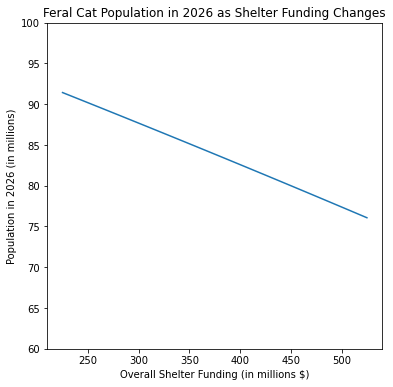

In [38]:
# find the slope of the tnr-shelter line (x: c_funding, y: pop 2026)

tnr_shelter_sim_x = tnr_shelter_sim_funding_df['Overall Shelter Funding (in millions $)']
tnr_shelter_sim_y = tnr_shelter_sim_funding_df['Population 2026 (in millions)']

plt.figure(figsize=(6, 6))
plt.ylim(60, 100)
plt.plot(tnr_shelter_sim_x, tnr_shelter_sim_y)
plt.xlabel('Overall Shelter Funding (in millions $)')
plt.ylabel('Population in 2026 (in millions)')
plt.title('Feral Cat Population in 2026 as Shelter Funding Changes')


In [39]:
# find the slope of the tnr-shelter line (x: c_funding, y: pop 2026)
tnr_shelter_sim_y = np.array(tnr_shelter_sim_y)
tnr_shelter_sim_x = np.array(tnr_shelter_sim_x)

m_y = tnr_shelter_sim_y[-1] - tnr_shelter_sim_y[0]
m_x = tnr_shelter_sim_x[-1] - tnr_shelter_sim_x[0]

m = np.round(np.abs(m_y / m_x) * 20, 2)
print(str(m) + ' million feral cats reduced for every additional $20M spent under TNR-Shelter Operations.') #matches with pop change 

1.02 million feral cats reduced for every additional $20M spent under TNR-Shelter Operations.


## Sensitivity analysis - funding: Current Policy 

In [40]:
# no TNR
sim_tnr_y_f = 0 * (10 ** 6)

In [41]:
sim_curr_fund_pop_2026 = []
sim_curr_funding_list = []
curr_funding_values = np.arange(225 * (10 ** 6), 544 * (10 ** 6), 20 * (10 ** 6))

for fund in curr_funding_values: 
    curr_fund_fertile_pop = []
    curr_fund_neutered_pop = []
    curr_fund_pop = []

    curr_fund_fertile_pop.append(pop_2021)
    curr_fund_neutered_pop.append(0)
    curr_fund_pop.append(pop_2021)

    for i in np.arange(1, 6):
        fertile_pop = pop_fertile(t=i, 
                               prev_pf = curr_fund_fertile_pop[-1],
                               prev_pn = curr_fund_neutered_pop[-1],
                               r0=curr_r0, 
                               c_f = fund, 
                               c_r = c_rescue, 
                               r_i = curr_r_i, 
                               base_cap_rate = curr_pop_cap, 
                               e_t = sim_gdp_growths_5_years[i],
                               cat_to_human_prop = us_cat_to_human_prop,
                               death_prop = curr_death_prop,
                               base_fac_fund = sim_tnr_y_f,
                                r_tnr_f_mean = r_tnr_f_avg, 
                               r_tnr_f_sd = r_tnr_f_std,
                               c_space = c_space_per_cat)

        neutered_pop = pop_neutered(t=i, 
                                 prev_pn = curr_fund_neutered_pop[-1],
                                 r0=curr_r0, 
                               c_f = fund, 
                               c_r = c_rescue, 
                               r_i = curr_r_i, 
                               base_cap_rate = curr_pop_cap, 
                               e_t = sim_gdp_growths_5_years[i],
                               cat_to_human_prop = us_cat_to_human_prop,
                               death_prop = curr_death_prop,
                               base_fac_fund = sim_tnr_y_f, 
                                r_tnr_f_mean = r_tnr_f_avg, 
                               r_tnr_f_sd = r_tnr_f_std,
                               c_space = c_space_per_cat)
    
        total_pop = fertile_pop + neutered_pop
   
        curr_fund_fertile_pop.append(fertile_pop)
        curr_fund_neutered_pop.append(neutered_pop)
        curr_fund_pop.append(total_pop)
    
    sim_curr_funding_list.append(fund)
    sim_curr_fund_pop_2026.append(curr_fund_pop[-1])

In [42]:
# get dataframe
sim_curr_funding_list = np.array(sim_curr_funding_list)
sim_curr_fund_pop_2026 = np.array(sim_curr_fund_pop_2026)


data = {'Base Shelter Funding (in millions $)': sim_curr_funding_list / 1000000,
       'Population 2026 (in millions)': sim_curr_fund_pop_2026 / 1000000}

curr_sim_funding_df = pd.DataFrame(data)
curr_sim_funding_df['Population Change (in millions)'] = np.round(curr_sim_funding_df[['Population 2026 (in millions)']].diff(), 2)
curr_sim_funding_df

,Base Shelter Funding (in millions $),Population 2026 (in millions),Population Change (in millions)
0,225.0,88.014451,NaN
1,245.0,86.718166,-1.30
2,265.0,85.418084,-1.30
3,285.0,84.114190,-1.30
4,305.0,82.806470,-1.31
5,325.0,81.494909,-1.31
6,345.0,80.179494,-1.32
7,365.0,78.860209,-1.32
8,385.0,77.537042,-1.32
9,405.0,76.209976,-1.33


In [43]:
curr_sim_pop_change_avg = np.round(curr_sim_funding_df[['Population Change (in millions)']].mean()[0], 2)
curr_sim_funding_change_millions_avg = 20 #increment for fund change

print('Population 2026 is expected to decrease by ' + str(abs(curr_sim_pop_change_avg)) 
      + ' million cats for every additional $' + str(curr_sim_funding_change_millions_avg) 
      + ' million spent under current (no TNR) policy.')


Population 2026 is expected to decrease by 1.32 million cats for every additional $20 million spent under current (no TNR) policy.


Text(0.5, 1.0, 'Feral Cat Population in 2026 as Baseline Shelter Funding Changes under Current Policy')

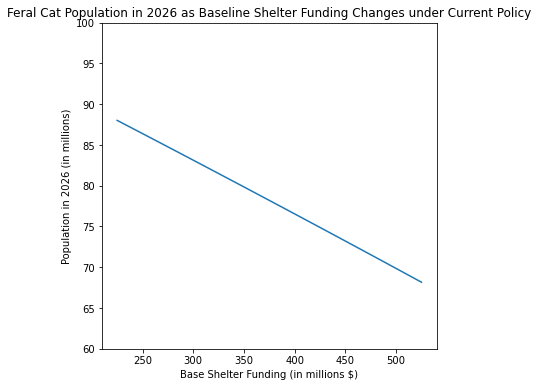

In [44]:
# graph curr_policy line (x: c_funding, y: pop 2026)

curr_sim_x = curr_sim_funding_df['Base Shelter Funding (in millions $)']
curr_sim_y = curr_sim_funding_df['Population 2026 (in millions)']

plt.figure(figsize=(6, 6))
plt.ylim(60, 100)
plt.plot(curr_sim_x, curr_sim_y)
plt.xlabel('Base Shelter Funding (in millions $)')
plt.ylabel('Population in 2026 (in millions)')
plt.title('Feral Cat Population in 2026 as Baseline Shelter Funding Changes under Current Policy')



## Sensitivity analysis - funding: TNR-Facility Policy


In [45]:
c_funding = 225 * (10 ** 6)
sim_tnr_facility_fund_pop_2026 = []
sim_tnr_facility_funding_list = []
tnr_facility_funding_values = np.arange(0 * (10 ** 6), 320 * (10 ** 6), 20 * (10 ** 6))

for fund in tnr_facility_funding_values: 
    curr_fund_fertile_pop = []
    curr_fund_neutered_pop = []
    curr_fund_pop = []

    curr_fund_fertile_pop.append(pop_2021)
    curr_fund_neutered_pop.append(0)
    curr_fund_pop.append(pop_2021)

    for i in np.arange(1, 6):
        fertile_pop = pop_fertile(t=i, 
                               prev_pf = curr_fund_fertile_pop[-1],
                               prev_pn = curr_fund_neutered_pop[-1],
                               r0=curr_r0, 
                               c_f = c_funding, 
                               c_r = c_rescue, 
                               r_i = curr_r_i, 
                               base_cap_rate = curr_pop_cap, 
                               e_t = sim_gdp_growths_5_years[i],
                               cat_to_human_prop = us_cat_to_human_prop,
                               death_prop = curr_death_prop,
                               base_fac_fund = fund,
                                r_tnr_f_mean = r_tnr_f_avg, 
                               r_tnr_f_sd = r_tnr_f_std,
                               c_space = c_space_per_cat)

        neutered_pop = pop_neutered(t=i, 
                                 prev_pn = curr_fund_neutered_pop[-1],
                                 r0=curr_r0, 
                               c_f = c_funding, 
                               c_r = c_rescue, 
                               r_i = curr_r_i, 
                               base_cap_rate = curr_pop_cap, 
                               e_t = sim_gdp_growths_5_years[i],
                               cat_to_human_prop = us_cat_to_human_prop,
                               death_prop = curr_death_prop,
                               base_fac_fund = fund, 
                                r_tnr_f_mean = r_tnr_f_avg, 
                               r_tnr_f_sd = r_tnr_f_std,
                               c_space = c_space_per_cat)
    
        total_pop = fertile_pop + neutered_pop
   
        curr_fund_fertile_pop.append(fertile_pop)
        curr_fund_neutered_pop.append(neutered_pop)
        curr_fund_pop.append(total_pop)
    
    sim_tnr_facility_funding_list.append(fund)
    sim_tnr_facility_fund_pop_2026.append(curr_fund_pop[-1])

In [46]:
# get dataframe
sim_tnr_facility_funding_list = np.array(sim_tnr_facility_funding_list)
sim_tnr_facility_fund_pop_2026 = np.array(sim_tnr_facility_fund_pop_2026)


data = {'TNR-Facility Funding (in millions $)': sim_tnr_facility_funding_list / 1000000,
       'Population 2026 (in millions)': sim_tnr_facility_fund_pop_2026 / 1000000}

tnr_facility_sim_funding_df = pd.DataFrame(data)
tnr_facility_sim_funding_df['Population Change (in millions)'] = np.round(tnr_facility_sim_funding_df[['Population 2026 (in millions)']].diff(), 2)
tnr_facility_sim_funding_df


,TNR-Facility Funding (in millions $),Population 2026 (in millions),Population Change (in millions)
0,0.0,88.014451,NaN
1,20.0,87.633724,-0.38
2,40.0,87.251995,-0.38
3,60.0,86.869256,-0.38
4,80.0,86.485499,-0.38
5,100.0,86.100714,-0.38
6,120.0,85.714895,-0.39
7,140.0,85.328033,-0.39
8,160.0,84.940119,-0.39
9,180.0,84.551145,-0.39


In [47]:
tnr_facility_sim_funding_df['Total Funding (in millions $)'] = 225 + tnr_facility_sim_funding_df['TNR-Facility Funding (in millions $)'] 
tnr_facility_sim_funding_df = tnr_facility_sim_funding_df[['TNR-Facility Funding (in millions $)', 'Total Funding (in millions $)', 
                                                           'Population 2026 (in millions)', 'Population Change (in millions)']]

tnr_facility_sim_funding_df


,TNR-Facility Funding (in millions $),Total Funding (in millions $),Population 2026 (in millions),Population Change (in millions)
0,0.0,225.0,88.014451,NaN
1,20.0,245.0,87.633724,-0.38
2,40.0,265.0,87.251995,-0.38
3,60.0,285.0,86.869256,-0.38
4,80.0,305.0,86.485499,-0.38
5,100.0,325.0,86.100714,-0.38
6,120.0,345.0,85.714895,-0.39
7,140.0,365.0,85.328033,-0.39
8,160.0,385.0,84.940119,-0.39
9,180.0,405.0,84.551145,-0.39


In [48]:
tnr_facility_sim_pop_change_avg = np.round(tnr_facility_sim_funding_df[['Population Change (in millions)']].mean()[0], 2)
tnr_facility_sim_funding_change_millions_avg = 20 #increment for fund change

print('Population 2026 is expected to decrease by ' + str(abs(tnr_facility_sim_pop_change_avg)) 
      + ' million cats for every additional $' + str(tnr_facility_sim_funding_change_millions_avg) 
      + ' million spent under TNR-facility policy.')



Population 2026 is expected to decrease by 0.39 million cats for every additional $20 million spent under TNR-facility policy.


Text(0.5, 1.0, 'Feral Cat Population in 2026 as TNR-Facility Funding Changes under TNR-Facility Policy')

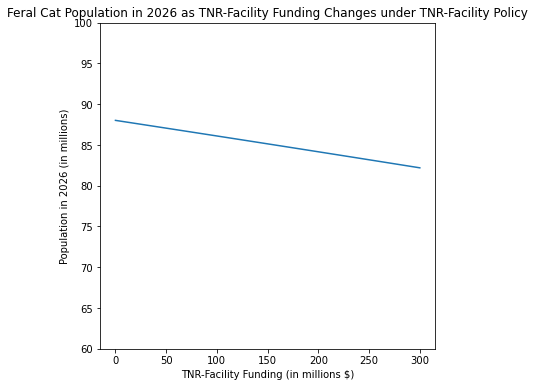

In [49]:
tnr_facility_sim_x = tnr_facility_sim_funding_df['TNR-Facility Funding (in millions $)']
tnr_facility_sim_y = tnr_facility_sim_funding_df['Population 2026 (in millions)']

plt.figure(figsize=(6, 6))
plt.ylim(60, 100)
plt.plot(tnr_facility_sim_x, tnr_facility_sim_y)
plt.xlabel('TNR-Facility Funding (in millions $)')
plt.ylabel('Population in 2026 (in millions)')
plt.title('Feral Cat Population in 2026 as TNR-Facility Funding Changes under TNR-Facility Policy')




### Compare Current Policy (at base $ 225M ) and TNR-shelter to find the intersection point 

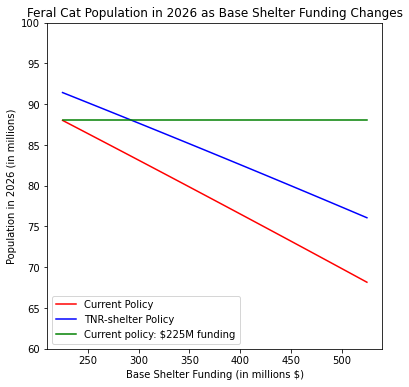

In [50]:
# graph curr_policy line (x: c_funding, y: pop 2026)

tnr_shelter_sim_x = tnr_shelter_sim_funding_df['Overall Shelter Funding (in millions $)']
tnr_shelter_sim_y = tnr_shelter_sim_funding_df['Population 2026 (in millions)']

curr_sim_x = curr_sim_funding_df['Base Shelter Funding (in millions $)']
curr_sim_y = curr_sim_funding_df['Population 2026 (in millions)']

plt.figure(figsize=(6, 6))
plt.ylim(60, 100)
plt.plot(curr_sim_x, curr_sim_y, color='r', label='Current Policy')
plt.plot(tnr_shelter_sim_x, tnr_shelter_sim_y, color='b', label='TNR-shelter Policy')
plt.plot(tnr_shelter_sim_x, [curr_sim_y[0]] * len(tnr_shelter_sim_x), color='g', label='Current policy: $225M funding')
plt.xlabel('Base Shelter Funding (in millions $)')
plt.ylabel('Population in 2026 (in millions)')
plt.title('Feral Cat Population in 2026 as Base Shelter Funding Changes')

plt.legend(loc="lower left")

In [51]:
curr_sim_funding_df_copy = curr_sim_funding_df.copy()
tnr_shelter_sim_funding_df_copy = tnr_shelter_sim_funding_df.copy()

curr_sim_funding_df_copy = curr_sim_funding_df_copy.rename(columns={'Base Shelter Funding (in millions $)': 'Overall Shelter Funding (in millions $)'})

sim_curr_tnr_shelter_fund_merge = curr_sim_funding_df_copy.merge(tnr_shelter_sim_funding_df_copy, on='Overall Shelter Funding (in millions $)')
sim_curr_tnr_shelter_fund_merge

sim_curr_tnr_shelter_fund_merge.columns = ['Base Shelter Funding (in millions $)', 'Current - Population 2026 (in M)', 
                                           'Current - Population Change (in M)', 'Base Funding TNR-Shelter (in millions $)', 
                                           'TNR-Shelter - Population 2026 (in M)', 'TNR-Shelter - Population Change (in M)']


In [52]:
sim_curr_tnr_shelter_fund_merge.columns = ['Base Shelter Funding (in millions $)', 
                                           'Current Policy: Population 2026 (in millions)', 
                                          'Current Policy: Pop Change (in millions)', 
                                          'TNR-Shelter Funding (in $ millions)', 
                                          'TNR-Shelter Policy: Population 2026 (in millions)',
                                          'TNR-Shelter Policy: Pop Change (in millions)']
sim_curr_tnr_shelter_fund_merge

,Base Shelter Funding (in millions $),Current Policy: Population 2026 (in millions),Current Policy: Pop Change (in millions),TNR-Shelter Funding (in $ millions),TNR-Shelter Policy: Population 2026 (in millions),TNR-Shelter Policy: Pop Change (in millions)
0,225.0,88.014451,NaN,127.80,91.424766,NaN
1,245.0,86.718166,-1.30,139.16,90.430982,-0.993784
2,265.0,85.418084,-1.30,150.52,89.433170,-0.997812
3,285.0,84.114190,-1.30,161.88,88.431287,-1.001883
4,305.0,82.806470,-1.31,173.24,87.425287,-1.006000
5,325.0,81.494909,-1.31,184.60,86.415124,-1.010163
6,345.0,80.179494,-1.32,195.96,85.400753,-1.014371
7,365.0,78.860209,-1.32,207.32,84.382126,-1.018627
8,385.0,77.537042,-1.32,218.68,83.359196,-1.022930
9,405.0,76.209976,-1.33,230.04,82.331914,-1.027282


In [53]:
sim_curr_tnr_shelter_fund_merge[['TNR-Shelter Policy: Pop Change (in millions)']].mean()

TNR-Shelter Policy: Pop Change (in millions)   -1.023382
dtype: float64

Text(0.5, 1.0, '2026 Population as Base Shelter Funding Increases under TNR-Shelter Policy')

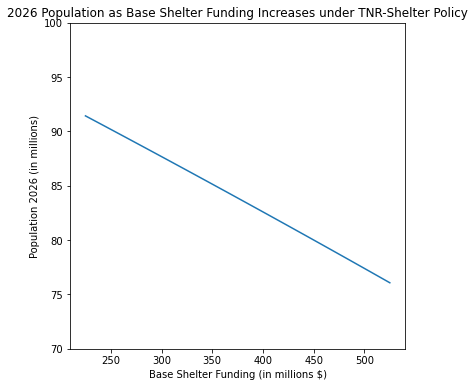

In [54]:
plt.figure(figsize=(6, 6))
plt.ylim(70, 100)
x = sim_curr_tnr_shelter_fund_merge['Base Shelter Funding (in millions $)']
y = sim_curr_tnr_shelter_fund_merge['TNR-Shelter Policy: Population 2026 (in millions)']
plt.plot(x, y)
plt.xlabel('Base Shelter Funding (in millions $)')
plt.ylabel('Population 2026 (in millions)')
plt.title('2026 Population as Base Shelter Funding Increases under TNR-Shelter Policy')

## Sensitivity Analysis: E_t - Current Policy

In [55]:
sim_tnr_y_f = 0 * (10 ** 6)
c_funding = 225 * (10 ** 6)

#sim_curr_gdp_pop_2026 = []
sim_curr_gdp_pops = []
curr_gdp_values = np.arange(-10, 11, 1) #simulate -10% to 10% growth 
sim_gdp_list = [] #for dataframe

for gdp_perc in curr_gdp_values: 
    curr_fund_fertile_pop = []
    curr_fund_neutered_pop = []
    curr_fund_pop = []

    curr_fund_fertile_pop.append(pop_2021)
    curr_fund_neutered_pop.append(0)
    curr_fund_pop.append(pop_2021)
    sim_curr_gdp_pops.append(pop_2021)
    sim_gdp_list.append(gdp_perc)

    for i in np.arange(1, 6):
        fertile_pop = pop_fertile(t=i, 
                               prev_pf = curr_fund_fertile_pop[-1],
                               prev_pn = curr_fund_neutered_pop[-1],
                               r0=curr_r0, 
                               c_f = c_funding, 
                               c_r = c_rescue, 
                               r_i = curr_r_i, 
                               base_cap_rate = curr_pop_cap, 
                               e_t = gdp_perc,
                               cat_to_human_prop = us_cat_to_human_prop,
                               death_prop = curr_death_prop,
                               base_fac_fund = sim_tnr_y_f,
                                r_tnr_f_mean = r_tnr_f_avg, 
                               r_tnr_f_sd = r_tnr_f_std,
                               c_space = c_space_per_cat)

        neutered_pop = pop_neutered(t=i, 
                                 prev_pn = curr_fund_neutered_pop[-1],
                                 r0=curr_r0, 
                               c_f = c_funding, 
                               c_r = c_rescue, 
                               r_i = curr_r_i, 
                               base_cap_rate = curr_pop_cap, 
                               e_t = gdp_perc,
                               cat_to_human_prop = us_cat_to_human_prop,
                               death_prop = curr_death_prop,
                               base_fac_fund = sim_tnr_y_f, 
                                r_tnr_f_mean = r_tnr_f_avg, 
                               r_tnr_f_sd = r_tnr_f_std,
                               c_space = c_space_per_cat)
    
        total_pop = fertile_pop + neutered_pop
   
        curr_fund_fertile_pop.append(fertile_pop)
        curr_fund_neutered_pop.append(neutered_pop)
        curr_fund_pop.append(total_pop)
    
        sim_curr_gdp_pops.append(total_pop)
        sim_gdp_list.append(gdp_perc)

In [56]:
# get dataframe
sim_gdp_list = np.array(sim_gdp_list)
sim_curr_gdp_pops = np.array(sim_curr_gdp_pops)
years = np.array([2021, 2022, 2023, 2024, 2025, 2026] * 21)


data = {'Year': years,
        'GDP Growth Percent (%)': sim_gdp_list,
       'Population (in millions)': sim_curr_gdp_pops / 1000000}

curr_sim_gdp_df = pd.DataFrame(data)
#curr_sim_gdp_df['Pop Change (in millions)'] = curr_sim_gdp_df[['Population 2026 (in millions)']].diff()
curr_sim_gdp_df_pivot = curr_sim_gdp_df.pivot(index='GDP Growth Percent (%)', columns='Year', values='Population (in millions)')
curr_sim_gdp_df_pivot = curr_sim_gdp_df_pivot.round(2)
curr_sim_gdp_df_pivot


Year,2021,2022,2023,2024,2025,2026
GDP Growth Percent (%),,,,,,
-10,70.0,75.15,79.27,82.62,85.36,87.63
-9,70.0,75.14,79.27,82.63,85.40,87.71
-8,70.0,75.13,79.27,82.65,85.44,87.78
-7,70.0,75.12,79.26,82.66,85.47,87.84
-6,70.0,75.11,79.26,82.66,85.50,87.90
-5,70.0,75.10,79.25,82.67,85.52,87.95
-4,70.0,75.09,79.24,82.67,85.54,87.99
-3,70.0,75.07,79.22,82.66,85.56,88.03
-2,70.0,75.06,79.20,82.65,85.57,88.07


Text(0.5, 1.0, '2026 Population vs. GDP Growth')

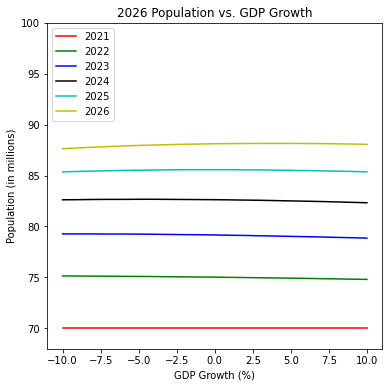

In [57]:
gdp_array = np.arange(-10, 11, 1)

pop_2021_line = curr_sim_gdp_df_pivot[2021]
pop_2022_line = curr_sim_gdp_df_pivot[2022]
pop_2023_line = curr_sim_gdp_df_pivot[2023]
pop_2024_line = curr_sim_gdp_df_pivot[2024]
pop_2025_line = curr_sim_gdp_df_pivot[2025]
pop_2026_line = curr_sim_gdp_df_pivot[2026]


#plot all 5 lines 
plt.figure(figsize=(6, 6))
plt.ylim(68, 100)
plt.plot(gdp_array, pop_2021_line, color = 'r', label='2021') #red
plt.plot(gdp_array, pop_2022_line, color = 'g', label='2022') #green
plt.plot(gdp_array, pop_2023_line, color = 'b', label='2023') #blue
plt.plot(gdp_array, pop_2024_line, color = 'k', label='2024') #black
plt.plot(gdp_array, pop_2025_line, color = 'c', label='2025') #cyan
plt.plot(gdp_array, pop_2026_line, color = 'y', label='2026') #yellow 
plt.legend(loc="upper left")


plt.xlabel('GDP Growth (%)')
plt.ylabel('Population (in millions)')
plt.title('2026 Population vs. GDP Growth')

In [58]:
#change in gdp growth % is 20 (from -10 to 10); GO WITH THIS ONE IN REPORT
pop_lines = [list(pop_2021_line), list(pop_2022_line), list(pop_2023_line), list(pop_2024_line), 
             list(pop_2025_line), list(pop_2026_line)]
    
pop_gdp_slopes = []
change_gdp_growth = 20

for line in pop_lines:
    pop_change = line[-1] - line[0]
    slope = (pop_change) / change_gdp_growth  #pop change in millions per % gdp growth 
    pop_gdp_slopes.append(slope)
    
data = {'Year': np.arange(2021, 2027),
       'Pop Change (in M cats) per 1% GDP inc': np.array(pop_gdp_slopes) * 1000000}
year_pop_gdp_slope_df = pd.DataFrame(data)
year_pop_gdp_slope_df

#'Pop Change per 1% GDP inc': pop_gdp_slopes,

,Year,Pop Change (in M cats) per 1% GDP inc
0,2021,0.0
1,2022,-17000.0
2,2023,-20500.0
3,2024,-14500.0
4,2025,0.0
5,2026,21500.0


In [59]:
#change in gdp growth % is 20 (from -10 to 10)
pop_lines = [list(pop_2021_line), list(pop_2022_line), list(pop_2023_line), list(pop_2024_line), 
             list(pop_2025_line), list(pop_2026_line)]
pop_rate_gdp_slopes = []
change_gdp_growth = 20

for line in pop_lines:
    pop_change = line[-1] - line[0]
    slope = (pop_change) / change_gdp_growth  #pop change in millions per % gdp growth 
    pop_rate_gdp_slopes.append(slope)
    
data = {'Year': np.arange(2021, 2027),
       'Pop Rate of Change per 1% GDP inc': pop_rate_gdp_slopes,
       'Pop Rate of Change (in M cats) per 1% GDP inc': np.array(pop_rate_gdp_slopes) * 1000000}
year_pop_gdp_slope_df = pd.DataFrame(data)
year_pop_gdp_slope_df

,Year,Pop Rate of Change per 1% GDP inc,Pop Rate of Change (in M cats) per 1% GDP inc
0,2021,0.0000,0.0
1,2022,-0.0170,-17000.0
2,2023,-0.0205,-20500.0
3,2024,-0.0145,-14500.0
4,2025,0.0000,0.0
5,2026,0.0215,21500.0


## For sensitivity of TNR-shelter 

In [60]:
# SIMULATION: Changing c_funding from 225M to 524M
sim_tnr_shelter_tnr_prop_pop_2026 = []
shelter_tnr_prop_list = np.arange(0, 0.58, 0.01)
c_funding = 225 * (10 ** 6)

for tnr_prop in shelter_tnr_prop_list:
    sim_tnr_shelter_fund_fertile_pop = []
    sim_tnr_shelter_fund_neutered_pop = []
    sim_tnr_shelter_fund_pop = []

    sim_tnr_shelter_fund_fertile_pop.append(pop_2021)
    sim_tnr_shelter_fund_neutered_pop.append(0)
    sim_tnr_shelter_fund_pop.append(pop_2021)

    for i in np.arange(1, 6):
        sim_tnr_shelter_fund_fertile_pop_i = pop_fertile_s(t=i, 
                                prev_pf = sim_tnr_shelter_fund_fertile_pop[-1],
                               prev_pn = sim_tnr_shelter_fund_neutered_pop[-1],
                               r0=curr_r0, 
                               c_f = c_funding, 
                               c_r = c_rescue, 
                               r_i = curr_r_i, 
                               base_cap_rate = curr_pop_cap, 
                               e_t = sim_gdp_growths_5_years[i],
                               cat_to_human_prop = us_cat_to_human_prop,
                               death_prop = curr_death_prop,
                               c_tnr = curr_c_tnr,
                                    p_tnr_s = tnr_prop)
        
        sim_tnr_shelter_fund_neutered_pop_i = pop_neutered_s(t=i, 
                            prev_pn = sim_tnr_shelter_fund_neutered_pop[-1],
                                 r0=curr_r0, 
                               c_f = c_funding, 
                               c_r = c_rescue, 
                               r_i = curr_r_i, 
                               base_cap_rate = curr_pop_cap, 
                               e_t = sim_gdp_growths_5_years[i],
                               cat_to_human_prop = us_cat_to_human_prop,
                               death_prop = curr_death_prop,
                               c_tnr = curr_c_tnr,
                                p_tnr_s = tnr_prop)
    
        sim_tnr_shelter_fund_total_pop_i = sim_tnr_shelter_fund_fertile_pop_i + sim_tnr_shelter_fund_neutered_pop_i
        #sim_tnr_shelter_fund_perc_change_i = ((sim_tnr_shelter_fund_total_pop_i -  tnr_pop_s[-1]) / tnr_pop_s[-1]) * 100
    
        sim_tnr_shelter_fund_fertile_pop.append(sim_tnr_shelter_fund_fertile_pop_i)
        sim_tnr_shelter_fund_neutered_pop.append(sim_tnr_shelter_fund_neutered_pop_i)
        sim_tnr_shelter_fund_pop.append(sim_tnr_shelter_fund_total_pop_i)
        #sim_tnr_shelter_fund_perc_change.append(yoy_s)
    
    sim_tnr_shelter_tnr_prop_pop_2026.append(sim_tnr_shelter_fund_pop[-1])
    

In [61]:
# get dataframe
sim_tnr_shelter_tnr_prop_pop_2026 = np.array(sim_tnr_shelter_tnr_prop_pop_2026)


data = {'TNR Operation Proportion at Shelter': shelter_tnr_prop_list,
       'Population 2026 (in millions)': sim_tnr_shelter_tnr_prop_pop_2026 / 1000000}

tnr_shelter_sim_tnr_prop_df = pd.DataFrame(data)
tnr_shelter_sim_tnr_prop_df['Pop Change (in millions)'] = tnr_shelter_sim_tnr_prop_df[['Population 2026 (in millions)']].diff()
tnr_shelter_sim_tnr_prop_df.iloc[[0, 1, 2, 3, 4, 5, 55, 56, 57], :]

,TNR Operation Proportion at Shelter,Population 2026 (in millions),Pop Change (in millions)
0,0.00,88.014451,NaN
1,0.01,88.074518,0.060067
2,0.02,88.134584,0.060066
3,0.03,88.194649,0.060065
4,0.04,88.254714,0.060064
5,0.05,88.314777,0.060063
55,0.55,91.316740,0.060016
56,0.56,91.376755,0.060015
57,0.57,91.436769,0.060014


In [62]:
# get slope/elasticity for tnr_prop 
tnr_prop_slope = tnr_shelter_sim_tnr_prop_df['Pop Change (in millions)'].mean()
print('Population in 2026 increases ' + str(tnr_prop_slope * 1000000) + ' cats per 1% increase in TNR operations at shelters.')

Population in 2026 increases 60040.67098881792 cats per 1% increase in TNR operations at shelters.


Text(0.5, 1.0, '2026 Population as TNR-Shelter Operations Increase under TNR-Shelter Policy')

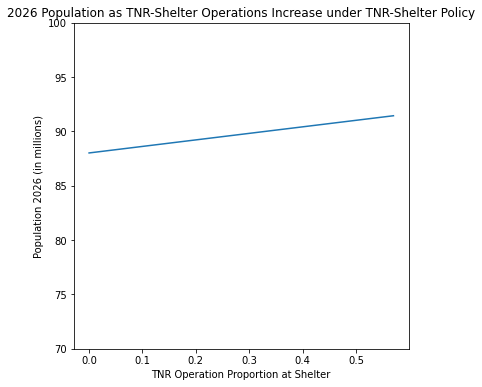

In [63]:
plt.figure(figsize=(6, 6))
plt.ylim(70, 100)
x = tnr_shelter_sim_tnr_prop_df['TNR Operation Proportion at Shelter']
y = tnr_shelter_sim_tnr_prop_df['Population 2026 (in millions)']
plt.plot(x, y)
plt.xlabel('TNR Operation Proportion at Shelter')
plt.ylabel('Population 2026 (in millions)')
plt.title('2026 Population as TNR-Shelter Operations Increase under TNR-Shelter Policy')

# ECONOMIC/COST ANALYSIS

1. Simulate for current policy w/o shelter funding --> get populations if there were no human management at all. 

2. Compare the simulated shelter funding (c_f) from [225M, 525M] & the population (for all 5 years for each funding amt) and calculate savings. 

3. See which is higher, etc. Get difference.

In [64]:
annual_damage_per_cat = 51.5
annual_damage_per_cat

51.5

## CURRENT POLICY

In [65]:
# no TNR
sim_tnr_y_f = 0 * (10 ** 6)
c_funding_values = np.arange(0 * (10 ** 6), 544 * (10 ** 6), 25 * (10 ** 6))

#sim_curr_gdp_pop_2026 = []
sim_curr_cost_pops = []
sim_fund_list = [] #for dataframe

for fund in c_funding_values: 
    curr_fund_fertile_pop = []
    curr_fund_neutered_pop = []
    curr_fund_pop = []

    curr_fund_fertile_pop.append(pop_2021)
    curr_fund_neutered_pop.append(0)
    curr_fund_pop.append(pop_2021)
    sim_curr_cost_pops.append(pop_2021)
    sim_fund_list.append(fund)

    for i in np.arange(1, 6):
        fertile_pop = pop_fertile(t=i, 
                               prev_pf = curr_fund_fertile_pop[-1],
                               prev_pn = curr_fund_neutered_pop[-1],
                               r0=curr_r0, 
                               c_f = fund, 
                               c_r = c_rescue, 
                               r_i = curr_r_i, 
                               base_cap_rate = curr_pop_cap, 
                               e_t = sim_gdp_growths_5_years[i],
                               cat_to_human_prop = us_cat_to_human_prop,
                               death_prop = curr_death_prop,
                               base_fac_fund = sim_tnr_y_f,
                                r_tnr_f_mean = r_tnr_f_avg, 
                               r_tnr_f_sd = r_tnr_f_std,
                               c_space = c_space_per_cat)

        neutered_pop = pop_neutered(t=i, 
                                 prev_pn = curr_fund_neutered_pop[-1],
                                 r0=curr_r0, 
                               c_f = fund, 
                               c_r = c_rescue, 
                               r_i = curr_r_i, 
                               base_cap_rate = curr_pop_cap, 
                               e_t = sim_gdp_growths_5_years[i],
                               cat_to_human_prop = us_cat_to_human_prop,
                               death_prop = curr_death_prop,
                               base_fac_fund = sim_tnr_y_f, 
                                r_tnr_f_mean = r_tnr_f_avg, 
                               r_tnr_f_sd = r_tnr_f_std,
                               c_space = c_space_per_cat)
    
        total_pop = fertile_pop + neutered_pop
   
        curr_fund_fertile_pop.append(fertile_pop)
        curr_fund_neutered_pop.append(neutered_pop)
        curr_fund_pop.append(total_pop)
    
        sim_curr_cost_pops.append(total_pop)
        sim_fund_list.append(fund)

In [66]:
# get dataframe
sim_fund_list = np.array(sim_fund_list)
sim_curr_cost_pops = np.array(sim_curr_cost_pops)
years = np.array([2021, 2022, 2023, 2024, 2025, 2026] * 22)


data = {'Year': years,
        'Base Shelter Spending (in M $)': sim_fund_list / 1000000,
       'Population (in millions)': sim_curr_cost_pops / 1000000}

curr_sim_cost_df = pd.DataFrame(data)
curr_sim_cost_df_pivot = curr_sim_cost_df.pivot(index='Base Shelter Spending (in M $)', columns='Year', values='Population (in millions)')
curr_sim_cost_df_pivot = curr_sim_cost_df_pivot.round(2)
curr_sim_cost_df_pivot


Year,2021,2022,2023,2024,2025,2026
Base Shelter Spending (in M $),,,,,,
0.0,70.0,78.05,85.13,91.56,96.97,102.34
25.0,70.0,77.71,84.47,90.57,95.71,100.77
50.0,70.0,77.37,83.81,89.58,94.45,99.20
75.0,70.0,77.03,83.15,88.58,93.19,97.62
100.0,70.0,76.69,82.49,87.59,91.93,96.03
125.0,70.0,76.35,81.83,86.60,90.66,94.44
150.0,70.0,76.01,81.17,85.61,89.39,92.84
175.0,70.0,75.66,80.51,84.61,88.12,91.24
200.0,70.0,75.32,79.84,83.61,86.84,89.63


In [67]:
#get population reduction (difference from $0 shelter funding) for each year & funding 

diff_2021 = np.zeros(len(curr_sim_cost_df_pivot.index))
diff_2022 = []
diff_2023 = []
diff_2024 = []
diff_2025 = []
diff_2026 = []

for row in curr_sim_cost_df_pivot.index:
    diff_list = list(curr_sim_cost_df_pivot.loc[0.0, :] - curr_sim_cost_df_pivot.loc[row, :])
    diff_2022.append(diff_list[1])
    diff_2023.append(diff_list[2])
    diff_2024.append(diff_list[3])
    diff_2025.append(diff_list[4])
    diff_2026.append(diff_list[5])
    
    
data = {'2021 Pop Diff (in M)': diff_2021,
        '2022 Pop Diff (in M)': diff_2022,
       '2023 Pop Diff (in M)': diff_2023,
       '2024 Pop Diff (in M)': diff_2024,
       '2025 Pop Diff (in M)': diff_2025,
       '2026 Pop Diff (in M)': diff_2026,}

curr_sim_cost_pop_diff_df = pd.DataFrame(data, index=curr_sim_cost_df_pivot.index)
curr_sim_cost_pop_diff_df


,2021 Pop Diff (in M),2022 Pop Diff (in M),2023 Pop Diff (in M),2024 Pop Diff (in M),2025 Pop Diff (in M),2026 Pop Diff (in M)
Base Shelter Spending (in M $),,,,,,
0.0,0.0,0.00,0.00,0.00,0.00,0.00
25.0,0.0,0.34,0.66,0.99,1.26,1.57
50.0,0.0,0.68,1.32,1.98,2.52,3.14
75.0,0.0,1.02,1.98,2.98,3.78,4.72
100.0,0.0,1.36,2.64,3.97,5.04,6.31
125.0,0.0,1.70,3.30,4.96,6.31,7.90
150.0,0.0,2.04,3.96,5.95,7.58,9.50
175.0,0.0,2.39,4.62,6.95,8.85,11.10
200.0,0.0,2.73,5.29,7.95,10.13,12.71


In [68]:
#amount saved from pop reduction per fund amount per year 

curr_sim_cost_savings_df = curr_sim_cost_pop_diff_df * annual_damage_per_cat
curr_sim_cost_savings_df.columns = ['2021 Savings (in millions $)', 
                                    '2022 Savings (in millions $)', 
                                   '2023 Savings (in millions $)', 
                                   '2024 Savings (in millions $)', 
                                   '2025 Savings (in millions $)', 
                                   '2026 Savings (in millions $)']
curr_sim_cost_savings_df  #could drop 2021 column

,2021 Savings (in millions $),2022 Savings (in millions $),2023 Savings (in millions $),2024 Savings (in millions $),2025 Savings (in millions $),2026 Savings (in millions $)
Base Shelter Spending (in M $),,,,,,
0.0,0.0,0.000,0.000,0.000,0.000,0.000
25.0,0.0,17.510,33.990,50.985,64.890,80.855
50.0,0.0,35.020,67.980,101.970,129.780,161.710
75.0,0.0,52.530,101.970,153.470,194.670,243.080
100.0,0.0,70.040,135.960,204.455,259.560,324.965
125.0,0.0,87.550,169.950,255.440,324.965,406.850
150.0,0.0,105.060,203.940,306.425,390.370,489.250
175.0,0.0,123.085,237.930,357.925,455.775,571.650
200.0,0.0,140.595,272.435,409.425,521.695,654.565


In [69]:
# net savings = savings - spending for each year w/resp to each fund amt 
curr_sim_cost_savings_df_copy = curr_sim_cost_savings_df.copy().reset_index()
curr_sim_cost_net_savings_df = curr_sim_cost_savings_df_copy

net_savings_2022 = curr_sim_cost_savings_df_copy['2022 Savings (in millions $)'] - curr_sim_cost_savings_df_copy['Base Shelter Spending (in M $)']
net_savings_2023 = curr_sim_cost_savings_df_copy['2023 Savings (in millions $)'] - curr_sim_cost_savings_df_copy['Base Shelter Spending (in M $)']
net_savings_2024 = curr_sim_cost_savings_df_copy['2024 Savings (in millions $)'] - curr_sim_cost_savings_df_copy['Base Shelter Spending (in M $)']
net_savings_2025 = curr_sim_cost_savings_df_copy['2025 Savings (in millions $)'] - curr_sim_cost_savings_df_copy['Base Shelter Spending (in M $)']
net_savings_2026 = curr_sim_cost_savings_df_copy['2026 Savings (in millions $)'] - curr_sim_cost_savings_df_copy['Base Shelter Spending (in M $)']

data = {'2022 Net Savings (in millions $)': list(net_savings_2022), 
        '2023 Net Savings (in millions $)': list(net_savings_2023),
        '2024 Net Savings (in millions $)': list(net_savings_2024),
        '2025 Net Savings (in millions $)': list(net_savings_2025),
        '2026 Net Savings (in millions $)': list(net_savings_2026)}

curr_sim_cost_net_savings_df = pd.DataFrame(data, index = curr_sim_cost_savings_df.index)
curr_sim_cost_net_savings_df
                                

,2022 Net Savings (in millions $),2023 Net Savings (in millions $),2024 Net Savings (in millions $),2025 Net Savings (in millions $),2026 Net Savings (in millions $)
Base Shelter Spending (in M $),,,,,
0.0,0.000,0.000,0.000,0.000,0.000
25.0,-7.490,8.990,25.985,39.890,55.855
50.0,-14.980,17.980,51.970,79.780,111.710
75.0,-22.470,26.970,78.470,119.670,168.080
100.0,-29.960,35.960,104.455,159.560,224.965
125.0,-37.450,44.950,130.440,199.965,281.850
150.0,-44.940,53.940,156.425,240.370,339.250
175.0,-51.915,62.930,182.925,280.775,396.650
200.0,-59.405,72.435,209.425,321.695,454.565


In [70]:
#get 5 year savings (compare 5-year spend = annual base fund * 5 vs cumulative 5-year savings)


curr_sim_cost_net_savings_df.sum(axis=1)  #5 year savings 

Base Shelter Spending (in M $)
0.0         0.000
25.0      123.230
50.0      246.460
75.0      370.720
100.0     494.980
125.0     619.755
150.0     745.045
175.0     871.365
200.0     998.715
225.0    1125.035
250.0    1252.900
275.0    1380.250
300.0    1509.145
325.0    1638.555
350.0    1767.450
375.0    1897.890
400.0    2029.360
425.0    2160.315
450.0    2291.785
475.0    2424.800
500.0    2557.300
525.0    2690.830
dtype: float64

In [71]:
# get dataframe of cumulative spendings & savings 

cumulative_spending = np.array(curr_sim_cost_savings_df.index) * 5
cumulative_saving = np.array(curr_sim_cost_net_savings_df.sum(axis=1))
net_savings_5_years = cumulative_saving - cumulative_spending

data = {'5-year Spending (in millions $)': cumulative_spending, 
       '5-year Saving (in millions $)': cumulative_saving, 
       '5-Year Net Saving (in millions $)': net_savings_5_years}

curr_sim_cost_5_year_savings_df = pd.DataFrame(data, index = curr_sim_cost_savings_df.index)
curr_sim_cost_5_year_savings_df

,5-year Spending (in millions $),5-year Saving (in millions $),5-Year Net Saving (in millions $)
Base Shelter Spending (in M $),,,
0.0,0.0,0.000,0.000
25.0,125.0,123.230,-1.770
50.0,250.0,246.460,-3.540
75.0,375.0,370.720,-4.280
100.0,500.0,494.980,-5.020
125.0,625.0,619.755,-5.245
150.0,750.0,745.045,-4.955
175.0,875.0,871.365,-3.635
200.0,1000.0,998.715,-1.285


## TNR-FACILITY POLICY

In [72]:
# no TNR
c_funding = 225 * (10 ** 6)
tnr_facility_funding_values = np.arange(0 * (10 ** 6), 320 * (10 ** 6), 20 * (10 ** 6))

#sim_curr_gdp_pop_2026 = []
sim_tnr_facility_cost_pops = []
sim_fund_list = [] #for dataframe

for fund in tnr_facility_funding_values: 
    curr_fund_fertile_pop = []
    curr_fund_neutered_pop = []
    curr_fund_pop = []

    curr_fund_fertile_pop.append(pop_2021)
    curr_fund_neutered_pop.append(0)
    curr_fund_pop.append(pop_2021)
    sim_tnr_facility_cost_pops.append(pop_2021)
    sim_fund_list.append(fund)

    for i in np.arange(1, 6):
        fertile_pop = pop_fertile(t=i, 
                               prev_pf = curr_fund_fertile_pop[-1],
                               prev_pn = curr_fund_neutered_pop[-1],
                               r0=curr_r0, 
                               c_f = c_funding, 
                               c_r = c_rescue, 
                               r_i = curr_r_i, 
                               base_cap_rate = curr_pop_cap, 
                               e_t = sim_gdp_growths_5_years[i],
                               cat_to_human_prop = us_cat_to_human_prop,
                               death_prop = curr_death_prop,
                               base_fac_fund = fund,
                                r_tnr_f_mean = r_tnr_f_avg, 
                               r_tnr_f_sd = r_tnr_f_std,
                               c_space = c_space_per_cat)

        neutered_pop = pop_neutered(t=i, 
                                 prev_pn = curr_fund_neutered_pop[-1],
                                 r0=curr_r0, 
                               c_f = c_funding, 
                               c_r = c_rescue, 
                               r_i = curr_r_i, 
                               base_cap_rate = curr_pop_cap, 
                               e_t = sim_gdp_growths_5_years[i],
                               cat_to_human_prop = us_cat_to_human_prop,
                               death_prop = curr_death_prop,
                               base_fac_fund = fund, 
                                r_tnr_f_mean = r_tnr_f_avg, 
                               r_tnr_f_sd = r_tnr_f_std,
                               c_space = c_space_per_cat)
    
        total_pop = fertile_pop + neutered_pop
   
        curr_fund_fertile_pop.append(fertile_pop)
        curr_fund_neutered_pop.append(neutered_pop)
        curr_fund_pop.append(total_pop)
    
        sim_tnr_facility_cost_pops.append(total_pop)
        sim_fund_list.append(fund)

In [73]:
# get dataframe
sim_fund_list = np.array(sim_fund_list)
sim_tnr_facility_cost_pops = np.array(sim_tnr_facility_cost_pops)
years = np.array([2021, 2022, 2023, 2024, 2025, 2026] * 16)


data = {'Year': years,
        'TNR-Facility Spending (in M $)': sim_fund_list / 1000000,
       'Population (in millions)': sim_tnr_facility_cost_pops / 1000000}

tnr_facility_sim_cost_df = pd.DataFrame(data)
#curr_sim_gdp_df['Pop Change (in millions)'] = curr_sim_gdp_df[['Population 2026 (in millions)']].diff()
tnr_facility_sim_cost_df_pivot = tnr_facility_sim_cost_df.pivot(index='TNR-Facility Spending (in M $)', columns='Year', values='Population (in millions)')
tnr_facility_sim_cost_df_pivot = tnr_facility_sim_cost_df_pivot.round(2)
tnr_facility_sim_cost_df_pivot



Year,2021,2022,2023,2024,2025,2026
TNR-Facility Spending (in M $),,,,,,
0.0,70.0,74.98,79.18,82.62,85.57,88.01
20.0,70.0,74.94,79.08,82.43,85.29,87.63
40.0,70.0,74.91,78.98,82.25,85.02,87.25
60.0,70.0,74.87,78.88,82.06,84.74,86.87
80.0,70.0,74.83,78.78,81.88,84.47,86.49
100.0,70.0,74.79,78.68,81.69,84.19,86.10
120.0,70.0,74.75,78.58,81.50,83.92,85.71
140.0,70.0,74.71,78.47,81.32,83.64,85.33
160.0,70.0,74.68,78.37,81.13,83.37,84.94


In [74]:
#get population reduction (difference from $0 shelter funding) for each year & funding 

diff_2021 = np.zeros(len(tnr_facility_sim_cost_df_pivot.index))
diff_2022 = []
diff_2023 = []
diff_2024 = []
diff_2025 = []
diff_2026 = []

for row in tnr_facility_sim_cost_df_pivot.index:
    diff_list = list(tnr_facility_sim_cost_df_pivot.loc[0.0, :] - tnr_facility_sim_cost_df_pivot.loc[row, :])
    diff_2022.append(diff_list[1])
    diff_2023.append(diff_list[2])
    diff_2024.append(diff_list[3])
    diff_2025.append(diff_list[4])
    diff_2026.append(diff_list[5])
    
    
data = {'2021 Pop Diff (in M)': diff_2021,
        '2022 Pop Diff (in M)': diff_2022,
       '2023 Pop Diff (in M)': diff_2023,
       '2024 Pop Diff (in M)': diff_2024,
       '2025 Pop Diff (in M)': diff_2025,
       '2026 Pop Diff (in M)': diff_2026,}

tnr_facility_sim_cost_pop_diff_df = pd.DataFrame(data, index=tnr_facility_sim_cost_df_pivot.index)
tnr_facility_sim_cost_pop_diff_df

,2021 Pop Diff (in M),2022 Pop Diff (in M),2023 Pop Diff (in M),2024 Pop Diff (in M),2025 Pop Diff (in M),2026 Pop Diff (in M)
TNR-Facility Spending (in M $),,,,,,
0.0,0.0,0.00,0.00,0.00,0.00,0.00
20.0,0.0,0.04,0.10,0.19,0.28,0.38
40.0,0.0,0.07,0.20,0.37,0.55,0.76
60.0,0.0,0.11,0.30,0.56,0.83,1.14
80.0,0.0,0.15,0.40,0.74,1.10,1.52
100.0,0.0,0.19,0.50,0.93,1.38,1.91
120.0,0.0,0.23,0.60,1.12,1.65,2.30
140.0,0.0,0.27,0.71,1.30,1.93,2.68
160.0,0.0,0.30,0.81,1.49,2.20,3.07


In [75]:
#amount saved from pop reduction per fund amount per year 
tnr_facility_sim_cost_savings_df = tnr_facility_sim_cost_pop_diff_df * annual_damage_per_cat
tnr_facility_sim_cost_savings_df.columns = ['2021 Savings (in millions $)', 
                                    '2022 Savings (in millions $)', 
                                   '2023 Savings (in millions $)', 
                                   '2024 Savings (in millions $)', 
                                   '2025 Savings (in millions $)', 
                                   '2026 Savings (in millions $)']
tnr_facility_sim_cost_savings_df  #could drop 2021 column

,2021 Savings (in millions $),2022 Savings (in millions $),2023 Savings (in millions $),2024 Savings (in millions $),2025 Savings (in millions $),2026 Savings (in millions $)
TNR-Facility Spending (in M $),,,,,,
0.0,0.0,0.000,0.000,0.000,0.000,0.000
20.0,0.0,2.060,5.150,9.785,14.420,19.570
40.0,0.0,3.605,10.300,19.055,28.325,39.140
60.0,0.0,5.665,15.450,28.840,42.745,58.710
80.0,0.0,7.725,20.600,38.110,56.650,78.280
100.0,0.0,9.785,25.750,47.895,71.070,98.365
120.0,0.0,11.845,30.900,57.680,84.975,118.450
140.0,0.0,13.905,36.565,66.950,99.395,138.020
160.0,0.0,15.450,41.715,76.735,113.300,158.105


In [76]:
# net savings = savings - spending for each year w/resp to each fund amt 
tnr_facility_sim_cost_savings_df_copy = tnr_facility_sim_cost_savings_df.copy().reset_index()
tnr_facility_sim_cost_net_savings_df = tnr_facility_sim_cost_savings_df_copy

net_savings_2022 = tnr_facility_sim_cost_savings_df_copy['2022 Savings (in millions $)'] - tnr_facility_sim_cost_savings_df_copy['TNR-Facility Spending (in M $)']
net_savings_2023 = tnr_facility_sim_cost_savings_df_copy['2023 Savings (in millions $)'] - tnr_facility_sim_cost_savings_df_copy['TNR-Facility Spending (in M $)']
net_savings_2024 = tnr_facility_sim_cost_savings_df_copy['2024 Savings (in millions $)'] - tnr_facility_sim_cost_savings_df_copy['TNR-Facility Spending (in M $)']
net_savings_2025 = tnr_facility_sim_cost_savings_df_copy['2025 Savings (in millions $)'] - tnr_facility_sim_cost_savings_df_copy['TNR-Facility Spending (in M $)']
net_savings_2026 = tnr_facility_sim_cost_savings_df_copy['2026 Savings (in millions $)'] - tnr_facility_sim_cost_savings_df_copy['TNR-Facility Spending (in M $)']

data = {'2022 Net Savings (in millions $)': list(net_savings_2022), 
        '2023 Net Savings (in millions $)': list(net_savings_2023),
        '2024 Net Savings (in millions $)': list(net_savings_2024),
        '2025 Net Savings (in millions $)': list(net_savings_2025),
        '2026 Net Savings (in millions $)': list(net_savings_2026)}

tnr_facility_sim_cost_net_savings_df = pd.DataFrame(data, index = tnr_facility_sim_cost_savings_df.index)
tnr_facility_sim_cost_net_savings_df
                                

,2022 Net Savings (in millions $),2023 Net Savings (in millions $),2024 Net Savings (in millions $),2025 Net Savings (in millions $),2026 Net Savings (in millions $)
TNR-Facility Spending (in M $),,,,,
0.0,0.000,0.000,0.000,0.000,0.000
20.0,-17.940,-14.850,-10.215,-5.580,-0.430
40.0,-36.395,-29.700,-20.945,-11.675,-0.860
60.0,-54.335,-44.550,-31.160,-17.255,-1.290
80.0,-72.275,-59.400,-41.890,-23.350,-1.720
100.0,-90.215,-74.250,-52.105,-28.930,-1.635
120.0,-108.155,-89.100,-62.320,-35.025,-1.550
140.0,-126.095,-103.435,-73.050,-40.605,-1.980
160.0,-144.550,-118.285,-83.265,-46.700,-1.895


In [77]:
# get dataframe of cumulative spendings & savings 

cumulative_spending = np.array(tnr_facility_sim_cost_savings_df.index) * 5
cumulative_saving = np.array(tnr_facility_sim_cost_savings_df.sum(axis=1))
net_savings_5_years = cumulative_saving - cumulative_spending

data = {'5-year Spending (in millions $)': cumulative_spending, 
       '5-year Saving (in millions $)': cumulative_saving, 
       '5-Year Net Saving (in millions $)': net_savings_5_years}

tnr_facility_sim_cost_5_year_savings_df = pd.DataFrame(data, index = tnr_facility_sim_cost_savings_df.index)
tnr_facility_sim_cost_5_year_savings_df

,5-year Spending (in millions $),5-year Saving (in millions $),5-Year Net Saving (in millions $)
TNR-Facility Spending (in M $),,,
0.0,0.0,0.000,0.000
20.0,100.0,50.985,-49.015
40.0,200.0,100.425,-99.575
60.0,300.0,151.410,-148.590
80.0,400.0,201.365,-198.635
100.0,500.0,252.865,-247.135
120.0,600.0,303.850,-296.150
140.0,700.0,354.835,-345.165
160.0,800.0,405.305,-394.695


## TNR-Shelter Policy 

In [78]:
# no TNR
sim_tnr_y_f = 0 * (10 ** 6)
c_funding_values = np.arange(0 * (10 ** 6), 544 * (10 ** 6), 25 * (10 ** 6))

#sim_curr_gdp_pop_2026 = []
sim_tnr_shelter_cost_pops = []
sim_fund_list = [] #for dataframe

for fund in c_funding_values: 
    sim_tnr_shelter_fund_fertile_pop = []
    sim_tnr_shelter_fund_neutered_pop = []
    sim_tnr_shelter_fund_pop = []
    sim_tnr_shelter_fund_perc_change = []  #percent change b/w latest pop 2026 and prev pop 2026 of diff fund amt

    sim_tnr_shelter_fund_fertile_pop.append(pop_2021)
    sim_tnr_shelter_fund_neutered_pop.append(0)
    sim_tnr_shelter_fund_pop.append(pop_2021)
    sim_tnr_shelter_fund_perc_change.append(0)
    sim_fund_list.append(fund)
    sim_tnr_shelter_cost_pops.append(pop_2021)

    #print(str(2021) + ' Pop (TNR Shelter): ' + str(tnr_pop_s[0]))
    #print('YoY Change: ' + str(tnr_yoy_s[-1]) + '%')

    for i in np.arange(1, 6):
        #print('i: ' + str(i))
        sim_tnr_shelter_fund_fertile_pop_i = pop_fertile_s(t=i, 
                                prev_pf = sim_tnr_shelter_fund_fertile_pop[-1],
                               prev_pn = sim_tnr_shelter_fund_neutered_pop[-1],
                               r0=curr_r0, 
                               c_f = fund, 
                               c_r = c_rescue, 
                               r_i = curr_r_i, 
                               base_cap_rate = curr_pop_cap, 
                               e_t = sim_gdp_growths_5_years[i],
                               cat_to_human_prop = us_cat_to_human_prop,
                               death_prop = curr_death_prop,
                               c_tnr = curr_c_tnr,
                                    p_tnr_s = curr_p_tnr_s)
        
        sim_tnr_shelter_fund_neutered_pop_i = pop_neutered_s(t=i, 
                            prev_pn = sim_tnr_shelter_fund_neutered_pop[-1],
                                 r0=curr_r0, 
                               c_f = fund, 
                               c_r = c_rescue, 
                               r_i = curr_r_i, 
                               base_cap_rate = curr_pop_cap, 
                               e_t = sim_gdp_growths_5_years[i],
                               cat_to_human_prop = us_cat_to_human_prop,
                               death_prop = curr_death_prop,
                               c_tnr = curr_c_tnr,
                                p_tnr_s = curr_p_tnr_s)
    
        sim_tnr_shelter_fund_total_pop_i = sim_tnr_shelter_fund_fertile_pop_i + sim_tnr_shelter_fund_neutered_pop_i
        #sim_tnr_shelter_fund_perc_change_i = ((sim_tnr_shelter_fund_total_pop_i -  tnr_pop_s[-1]) / tnr_pop_s[-1]) * 100
    
        sim_tnr_shelter_fund_fertile_pop.append(sim_tnr_shelter_fund_fertile_pop_i)
        sim_tnr_shelter_fund_neutered_pop.append(sim_tnr_shelter_fund_neutered_pop_i)
        sim_tnr_shelter_fund_pop.append(sim_tnr_shelter_fund_total_pop_i)
        #sim_tnr_shelter_fund_perc_change.append(yoy_s)
        
        sim_fund_list.append(fund)
        sim_tnr_shelter_cost_pops.append(sim_tnr_shelter_fund_total_pop_i)
        
        

In [79]:
# get dataframe
sim_fund_list = np.array(sim_fund_list)
sim_tnr_shelter_cost_pops = np.array(sim_tnr_shelter_cost_pops)
years = np.array([2021, 2022, 2023, 2024, 2025, 2026] * 22)


data = {'Year': years,
        'TNR-Shelter Spending (in M $)': sim_fund_list / 1000000,
       'Population (in millions)': sim_tnr_shelter_cost_pops / 1000000}

tnr_shelter_sim_cost_df = pd.DataFrame(data)
#curr_sim_gdp_df['Pop Change (in millions)'] = curr_sim_gdp_df[['Population 2026 (in millions)']].diff()
tnr_shelter_sim_cost_df_pivot = tnr_shelter_sim_cost_df.pivot(index='TNR-Shelter Spending (in M $)', columns='Year', values='Population (in millions)')
tnr_shelter_sim_cost_df_pivot = tnr_shelter_sim_cost_df_pivot.round(2)
tnr_shelter_sim_cost_df_pivot



Year,2021,2022,2023,2024,2025,2026
TNR-Shelter Spending (in M $),,,,,,
0.0,70.0,78.05,85.13,91.56,96.97,102.34
25.0,70.0,77.85,84.70,90.87,96.05,101.15
50.0,70.0,77.65,84.27,90.19,95.13,99.96
75.0,70.0,77.45,83.85,89.50,94.21,98.75
100.0,70.0,77.25,83.42,88.81,93.29,97.55
125.0,70.0,77.04,82.99,88.12,92.36,96.33
150.0,70.0,76.84,82.56,87.43,91.43,95.12
175.0,70.0,76.64,82.13,86.74,90.50,93.89
200.0,70.0,76.44,81.70,86.05,89.56,92.66


In [80]:
#get population reduction (difference from $0 shelter funding) for each year & funding 

diff_2021 = np.zeros(len(tnr_shelter_sim_cost_df_pivot.index))
diff_2022 = []
diff_2023 = []
diff_2024 = []
diff_2025 = []
diff_2026 = []

for row in tnr_shelter_sim_cost_df_pivot.index:
    diff_list = list(tnr_shelter_sim_cost_df_pivot.loc[0.0, :] - tnr_shelter_sim_cost_df_pivot.loc[row, :])
    diff_2022.append(diff_list[1])
    diff_2023.append(diff_list[2])
    diff_2024.append(diff_list[3])
    diff_2025.append(diff_list[4])
    diff_2026.append(diff_list[5])
    
    
data = {'2021 Pop Diff (in M)': diff_2021,
        '2022 Pop Diff (in M)': diff_2022,
       '2023 Pop Diff (in M)': diff_2023,
       '2024 Pop Diff (in M)': diff_2024,
       '2025 Pop Diff (in M)': diff_2025,
       '2026 Pop Diff (in M)': diff_2026,}

tnr_shelter_sim_cost_pop_diff_df = pd.DataFrame(data, index=tnr_shelter_sim_cost_df_pivot.index)
tnr_shelter_sim_cost_pop_diff_df

,2021 Pop Diff (in M),2022 Pop Diff (in M),2023 Pop Diff (in M),2024 Pop Diff (in M),2025 Pop Diff (in M),2026 Pop Diff (in M)
TNR-Shelter Spending (in M $),,,,,,
0.0,0.0,0.00,0.00,0.00,0.00,0.00
25.0,0.0,0.20,0.43,0.69,0.92,1.19
50.0,0.0,0.40,0.86,1.37,1.84,2.38
75.0,0.0,0.60,1.28,2.06,2.76,3.59
100.0,0.0,0.80,1.71,2.75,3.68,4.79
125.0,0.0,1.01,2.14,3.44,4.61,6.01
150.0,0.0,1.21,2.57,4.13,5.54,7.22
175.0,0.0,1.41,3.00,4.82,6.47,8.45
200.0,0.0,1.61,3.43,5.51,7.41,9.68


In [81]:
#amount saved from pop reduction per fund amount per year 
tnr_shelter_sim_cost_savings_df = tnr_shelter_sim_cost_pop_diff_df * annual_damage_per_cat
tnr_shelter_sim_cost_savings_df.columns = ['2021 Savings (in millions $)', 
                                    '2022 Savings (in millions $)', 
                                   '2023 Savings (in millions $)', 
                                   '2024 Savings (in millions $)', 
                                   '2025 Savings (in millions $)', 
                                   '2026 Savings (in millions $)']
tnr_shelter_sim_cost_savings_df  #could drop 2021 column

,2021 Savings (in millions $),2022 Savings (in millions $),2023 Savings (in millions $),2024 Savings (in millions $),2025 Savings (in millions $),2026 Savings (in millions $)
TNR-Shelter Spending (in M $),,,,,,
0.0,0.0,0.000,0.000,0.000,0.000,0.000
25.0,0.0,10.300,22.145,35.535,47.380,61.285
50.0,0.0,20.600,44.290,70.555,94.760,122.570
75.0,0.0,30.900,65.920,106.090,142.140,184.885
100.0,0.0,41.200,88.065,141.625,189.520,246.685
125.0,0.0,52.015,110.210,177.160,237.415,309.515
150.0,0.0,62.315,132.355,212.695,285.310,371.830
175.0,0.0,72.615,154.500,248.230,333.205,435.175
200.0,0.0,82.915,176.645,283.765,381.615,498.520


In [82]:
tnr_shelter_sim_cost_savings_df_copy = tnr_shelter_sim_cost_savings_df.copy().reset_index()
tnr_shelter_sim_cost_net_savings_df = tnr_shelter_sim_cost_savings_df_copy

net_savings_2022 = tnr_shelter_sim_cost_savings_df_copy['2022 Savings (in millions $)'] - tnr_shelter_sim_cost_savings_df_copy['TNR-Shelter Spending (in M $)']
net_savings_2023 = tnr_shelter_sim_cost_savings_df_copy['2023 Savings (in millions $)'] - tnr_shelter_sim_cost_savings_df_copy['TNR-Shelter Spending (in M $)']
net_savings_2024 = tnr_shelter_sim_cost_savings_df_copy['2024 Savings (in millions $)'] - tnr_shelter_sim_cost_savings_df_copy['TNR-Shelter Spending (in M $)']
net_savings_2025 = tnr_shelter_sim_cost_savings_df_copy['2025 Savings (in millions $)'] - tnr_shelter_sim_cost_savings_df_copy['TNR-Shelter Spending (in M $)']
net_savings_2026 = tnr_shelter_sim_cost_savings_df_copy['2026 Savings (in millions $)'] - tnr_shelter_sim_cost_savings_df_copy['TNR-Shelter Spending (in M $)']

data = {'2022 Net Savings (in millions $)': list(net_savings_2022), 
        '2023 Net Savings (in millions $)': list(net_savings_2023),
        '2024 Net Savings (in millions $)': list(net_savings_2024),
        '2025 Net Savings (in millions $)': list(net_savings_2025),
        '2026 Net Savings (in millions $)': list(net_savings_2026)}

tnr_shelter_sim_cost_net_savings_df = pd.DataFrame(data, index = tnr_shelter_sim_cost_savings_df.index)
tnr_shelter_sim_cost_net_savings_df


,2022 Net Savings (in millions $),2023 Net Savings (in millions $),2024 Net Savings (in millions $),2025 Net Savings (in millions $),2026 Net Savings (in millions $)
TNR-Shelter Spending (in M $),,,,,
0.0,0.000,0.000,0.000,0.000,0.000
25.0,-14.700,-2.855,10.535,22.380,36.285
50.0,-29.400,-5.710,20.555,44.760,72.570
75.0,-44.100,-9.080,31.090,67.140,109.885
100.0,-58.800,-11.935,41.625,89.520,146.685
125.0,-72.985,-14.790,52.160,112.415,184.515
150.0,-87.685,-17.645,62.695,135.310,221.830
175.0,-102.385,-20.500,73.230,158.205,260.175
200.0,-117.085,-23.355,83.765,181.615,298.520


In [83]:
# get dataframe of cumulative spendings & savings 

cumulative_spending = np.array(tnr_shelter_sim_cost_net_savings_df.index) * 5
cumulative_saving = np.array(tnr_shelter_sim_cost_net_savings_df.sum(axis=1))
net_savings_5_years = cumulative_saving - cumulative_spending

data = {'5-year Spending (in millions $)': cumulative_spending, 
       '5-year Saving (in millions $)': cumulative_saving, 
       '5-Year Net Saving (in millions $)': net_savings_5_years}

tnr_shelter_sim_cost_5_year_savings_df = pd.DataFrame(data, index = tnr_shelter_sim_cost_savings_df.index)
tnr_shelter_sim_cost_5_year_savings_df

,5-year Spending (in millions $),5-year Saving (in millions $),5-Year Net Saving (in millions $)
TNR-Shelter Spending (in M $),,,
0.0,0.0,0.000,0.000
25.0,125.0,51.645,-73.355
50.0,250.0,102.775,-147.225
75.0,375.0,154.935,-220.065
100.0,500.0,207.095,-292.905
125.0,625.0,261.315,-363.685
150.0,750.0,314.505,-435.495
175.0,875.0,368.725,-506.275
200.0,1000.0,423.460,-576.540
